[Clustering](#Section1)
*  [EDA](#Section1.1)
*  [Feature Engineering](#Section1.2)
*  [K-Mean](#Section1.3)
*  [Heirarchicle/Ward](#Section1.4)
*  [DBSCAN](#Section1.5)
*  [Conclusion](#Section1.6)

[ARM](#Section2)
*   [EDA](#Section2.1)
*   [ARM Code in R](#Section2.2)
*   [ARM Code in Python](#Section2.3)














# E- Commerce Data Analysis using ML Algorithms (UnSupervised)

In the previous section of the project, we gathered data, performed cleasing, combining, and EDA. In this section of the project, we are going to take the subset of data we gathered and cleaned to answer the below questions using non-supervised learning algorithms Clustering and Association Rule Mining.

Question:

1.   Do sellers share any traits in common? Can they be grouped into groups that adhere to the same values and behave in the same ways on the market?
2.   Are there any patterns in customer purchases?  Do some itmes occur frequently in a transaction?



<a name="Section1"></a>

# 1. Do sellers share any traits in common? Can they be grouped into groups that adhere to the same values and behave in the same ways on the market?

<a name="Section1.1"></a>

#### EDA

For this we will need portion of data that we collected. We have already cleaned data in the previous section.

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import plotly.graph_objs as go
from sklearn.cluster import DBSCAN


In the last section we took an export of data in csv file. I've uploaded csv file on the drive and reading it data from there.

In [ ]:
# fetching geolocations data from google drive
url='https://drive.google.com/file/d/13Aw-m4FGy9oebV5L4wdNmjMF3ROy_scl/view?usp=sharing' 
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(dwn_url)

In [ ]:
df.head()

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,...,product_width_cm,product_category_name_english,review_score,seller_zip_code_prefix,seller_city,seller_state,customer x,customer y,seller x,seller y
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,144,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16,...,31.0,office_furniture,4.0,857,itaquaquecetuba,SP,-5.197407e+06,-2.700897e+06,-5.162385e+06,-2.690489e+06
1,1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,680,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,2017-11-10,...,31.0,office_furniture,1.0,857,itaquaquecetuba,SP,-5.214840e+06,-2.710450e+06,-5.162385e+06,-2.690489e+06
2,2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,680,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,2017-11-10,...,31.0,office_furniture,1.0,857,itaquaquecetuba,SP,-5.214840e+06,-2.710450e+06,-5.162385e+06,-2.690489e+06
3,3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,924,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07,2017-05-08,...,31.0,office_furniture,3.0,857,itaquaquecetuba,SP,-5.179084e+06,-2.708309e+06,-5.162385e+06,-2.690489e+06
4,4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,259,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03,2018-02-04,...,31.0,office_furniture,4.0,857,itaquaquecetuba,SP,-5.195393e+06,-2.694159e+06,-5.162385e+06,-2.690489e+06


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114914 entries, 0 to 114913
Data columns (total 44 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Unnamed: 0                                            114914 non-null  int64  
 1   customer_id                                           114914 non-null  object 
 2   customer_unique_id                                    114914 non-null  object 
 3   customer_zip_code_prefix                              114914 non-null  int64  
 4   customer_city                                         114914 non-null  object 
 5   customer_state                                        114914 non-null  object 
 6   order_id                                              114914 non-null  object 
 7   order_status                                          114914 non-null  object 
 8   order_purchase_timestamp                    

We do not need all the columns for our analysis. Let's select the required columns and drop rest of the columns.

In [ ]:
df =df[['customer_state','order_id', 'order_status','days diff between order placed and delivered date','days diff between order estimated and delivered date','order_item_id','product_id','seller_id','payment_type','payment_value','product_name_lenght','product_description_lenght','product_photos_qty','product_category_name_english','review_score','seller_state']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114914 entries, 0 to 114913
Data columns (total 16 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   customer_state                                        114914 non-null  object 
 1   order_id                                              114914 non-null  object 
 2   order_status                                          114914 non-null  object 
 3   days diff between order placed and delivered date     112534 non-null  float64
 4   days diff between order estimated and delivered date  112534 non-null  float64
 5   order_item_id                                         114914 non-null  int64  
 6   product_id                                            114914 non-null  object 
 7   seller_id                                             114914 non-null  object 
 8   payment_type                                

In [ ]:
df.head()

,customer_state,order_id,order_status,days diff between order placed and delivered date,days diff between order estimated and delivered date,order_item_id,product_id,seller_id,payment_type,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,review_score,seller_state
0,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,9.0,-11.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,credit_card,146.87,41.0,1141.0,1.0,office_furniture,4.0,SP
1,PA,c1d2b34febe9cd269e378117d6681172,delivered,19.0,-21.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,credit_card,275.79,41.0,1141.0,1.0,office_furniture,1.0,SP
2,PA,c1d2b34febe9cd269e378117d6681172,delivered,19.0,-21.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,credit_card,275.79,41.0,1141.0,1.0,office_furniture,1.0,SP
3,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,19.0,-17.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,credit_card,140.61,41.0,1141.0,1.0,office_furniture,3.0,SP
4,RJ,2e604b3614664aa66867856dba7e61b7,delivered,25.0,-22.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,credit_card,137.58,41.0,1141.0,1.0,office_furniture,4.0,SP


We will just consider orders which are completed i.e. delivered. 

In [ ]:
# aggerigating orders by order_status
df.groupby('order_status')['order_id'].count()

order_status
approved            3
canceled          532
delivered      112535
invoiced          353
processing        357
shipped          1127
unavailable         7
Name: order_id, dtype: int64

In [ ]:
# keep only delivered orders.
df = df[df['order_status'] == 'delivered']

In [ ]:
# Drop order status column as we no longer need it
df= df.drop('order_status', axis=1)

Before diving into answering above questions, let's deep dive into data. 

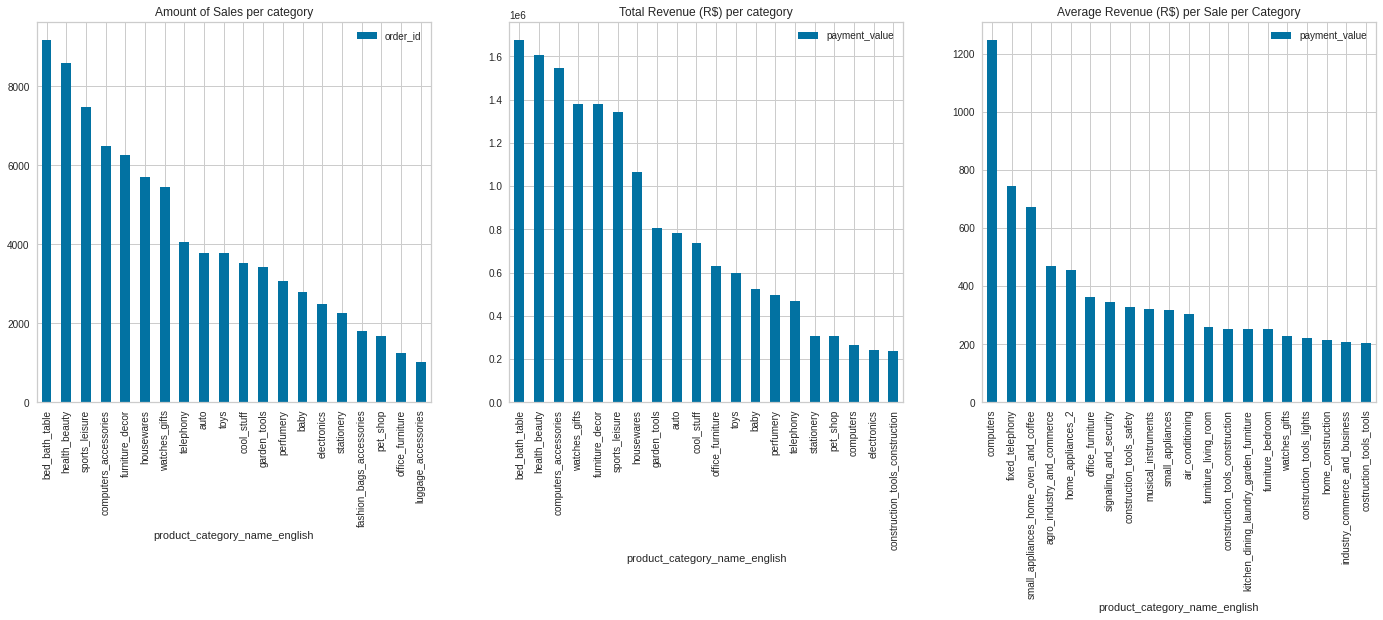

In [ ]:
# visuaize order count, total revenue and avg order revenue per product category

fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,3),(0,0))
df.groupby("product_category_name_english").agg({"order_id": "nunique"})\
.sort_values('order_id', ascending=False).head(20).plot.\
bar(title='Amount of Sales per category', ax=axes)

axes = plt.subplot2grid((1,3),(0,1))
df.groupby("product_category_name_english").agg({"payment_value": "sum"})\
.sort_values('payment_value', ascending=False).head(20).plot.\
bar(title='Total Revenue (R$) per category',ax=axes)

axes = plt.subplot2grid((1,3),(0,2))
df.groupby("product_category_name_english").agg({"payment_value": "mean"})\
.sort_values('payment_value', ascending=False).head(20).plot.\
bar(title='Average Revenue (R$) per Sale per Category',ax=axes)

Bed bath and health beauty products are the most sold products on platform and also most revenue generating products. However, computers are leading Avg. revenue per sale. 

The dataset has far too many categories for a person to comprehend. So, we will only take top 10 categories into account because encoding (one hot encoding) is required to run the algorithms.

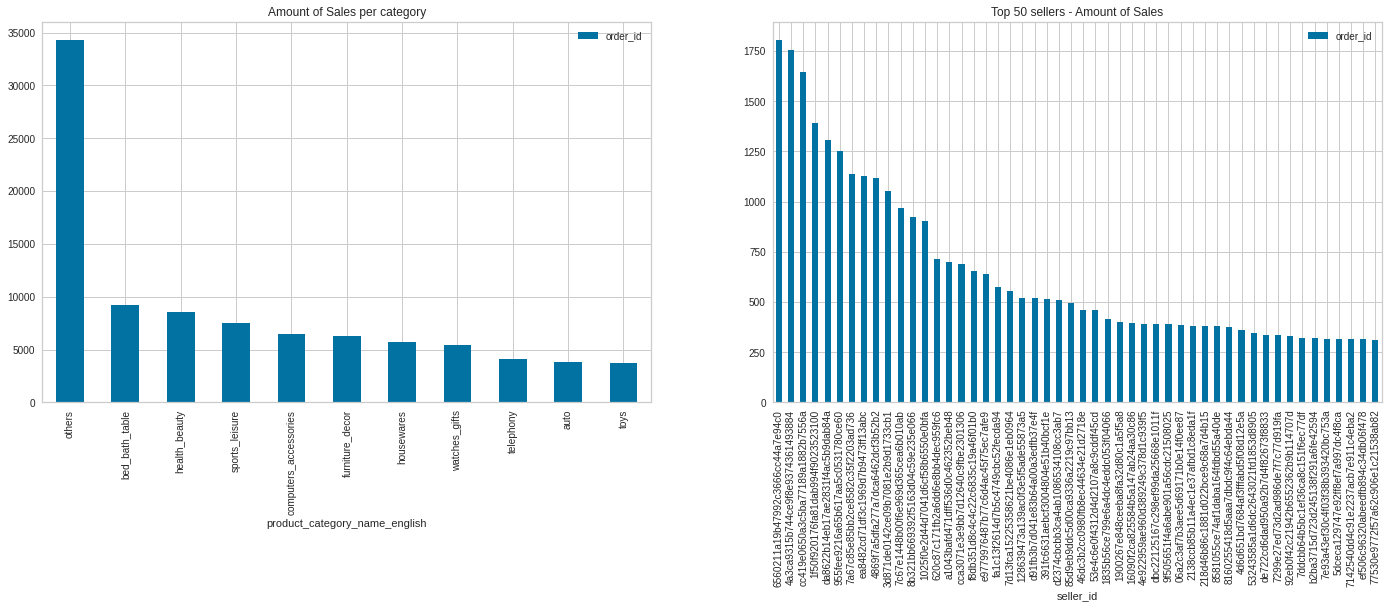

In [ ]:
# make a descending list of product categories as per order count 

prod_cat_name = df.groupby("product_category_name_english")\
.agg({"order_id": "nunique"}).sort_values('order_id', ascending=False).index.\
to_list()

# Keep top 10 categories and replace rest with "others"
outras_cat = list((Counter(prod_cat_name)-Counter(prod_cat_name[0:10])).elements())
df = df.replace(outras_cat,'others')

fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
df.groupby("product_category_name_english").agg({"order_id": "nunique"})\
.sort_values('order_id', ascending=False).plot.\
bar(title='Amount of Sales per category',ax=axes)

prod_cat_name = prod_cat_name[0:10]
prod_cat_name.append('others')
prod_cat_name.sort()

axes = plt.subplot2grid((1,2),(0,1))
df.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False).head(50).plot.bar(
    title='Top 50 sellers - Amount of Sales',ax=axes)

We can see above that we have some real good sellers. One of them almost reached 2k sales!

from our last analysis we know we have lot of sellers who did only one sell, let's see number of sellers with only one sell.

In [ ]:
# group sellers by number of sells
aux_seller = df.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False)

#total sellers and their sales count
N_totalsellers,aux = df.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False).shape

# sellers who made only one sell
N_uniquesell,aux = aux_seller[aux_seller.order_id==1].shape

#print(N_uniquesell)
#print(N_totalsellers)

#% of sellers with only one sell
print(f'There is {round(((N_uniquesell)/N_totalsellers)*100,2)}% sellers with only one sale.')

There is 18.47% sellers with only one sale.


We have already saw, many sellers and customers are located in the Southeast, south part of country, and bearly located in the rest part of country. To make our analysis easier, let's group rest of them as 'Other'.

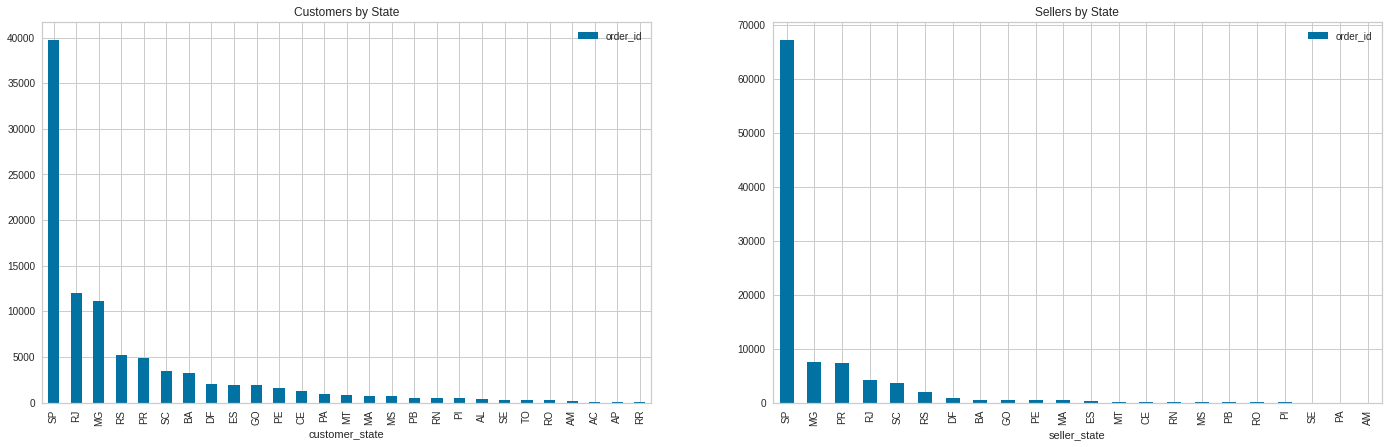

In [ ]:
# plotting customers by state and sellers by state

fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))

# Grouping customers by State
df.groupby('customer_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title='Customers by State',ax=axes)

# Grouping sellers by state
axes = plt.subplot2grid((1,2),(0,1))
df.groupby('seller_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title='Sellers by State',ax=axes)

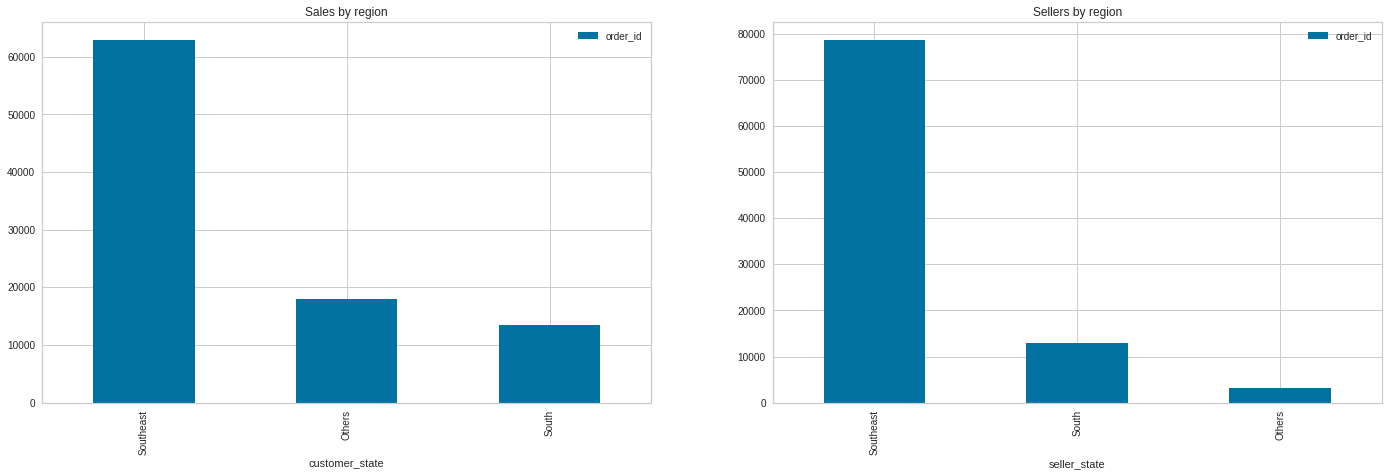

In [ ]:
# Group customers by state
States = df.groupby('customer_state').agg({'order_id':'nunique'})

Southeast = ['SP','RJ','MG']
South = ['RS','SC','PR']
Others = list((Counter(States.index)-Counter(Southeast)-Counter(South)).elements())

df = df.replace(Southeast,'Southeast')
df = df.replace(South,'South')
df = df.replace(Others,'Others')

fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
df.groupby('customer_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title = 'Sales by region',
                                          ax=axes)
axes = plt.subplot2grid((1,2),(0,1))
df.groupby('seller_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title = 'Sellers by region',
                                          ax=axes)

The southeast dominance is still present, but like these we will have less columns when applying the one hot encoding.

Let's take a look at Payment type column.

In [ ]:
df.groupby('payment_type')['order_id'].count()

payment_type
boleto         21887
credit_card    83067
debit_card      1615
voucher         5966
Name: order_id, dtype: int64

As we know, boleto us one of the famous payment method in Brazil, which was managed by Brazilian Federation of Banks.

<a name="Section1.2"></a>

#### Feature Engineering

We know to perform cluster analysis we need numeric data. But, we have few columns in object format, let's convert them to numeric by One hot Encoding Method

One hot Encoding

In [ ]:
# We will use One Hot Encoder from Sklearn.

enc = OneHotEncoder(sparse = False)


df[['Cust_Others','Cust_South','Cust_Southeast']] = enc.fit_transform(
    df[['customer_state']])

df[['Sel_Others','Sel_South','Sel_Southeast']] = enc.fit_transform(
    df[['seller_state']])

df[prod_cat_name] = enc.fit_transform(df[['product_category_name_english']])

df[['boleto','credit_card','debit_card','voucher']] = enc.fit_transform(df[['payment_type']])

# drop columns
df_encoded = df.drop(['customer_state','seller_state',
                            'product_category_name_english', 'payment_type'],axis=1)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112535 entries, 0 to 114913
Data columns (total 32 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   order_id                                              112535 non-null  object 
 1   days diff between order placed and delivered date     112527 non-null  float64
 2   days diff between order estimated and delivered date  112527 non-null  float64
 3   order_item_id                                         112535 non-null  int64  
 4   product_id                                            112535 non-null  object 
 5   seller_id                                             112535 non-null  object 
 6   payment_value                                         112535 non-null  float64
 7   product_name_lenght                                   112535 non-null  float64
 8   product_description_lenght                  

In [ ]:
df_encoded.head()

,order_id,days diff between order placed and delivered date,days diff between order estimated and delivered date,order_item_id,product_id,seller_id,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,...,housewares,others,sports_leisure,telephony,toys,watches_gifts,boleto,credit_card,debit_card,voucher
0,00e7ee1b050b8499577073aeb2a297a1,9.0,-11.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,146.87,41.0,1141.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,c1d2b34febe9cd269e378117d6681172,19.0,-21.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,275.79,41.0,1141.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,c1d2b34febe9cd269e378117d6681172,19.0,-21.0,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,275.79,41.0,1141.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,b1a5d5365d330d10485e0203d54ab9e8,19.0,-17.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,140.61,41.0,1141.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2e604b3614664aa66867856dba7e61b7,25.0,-22.0,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,137.58,41.0,1141.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


So far, we have essentially combined order information. We must now compile this information for sellers. We'll accomplish this using the groupby. The aggregate was done in terms of mean value for certain variables, maximum value for others, and sum for others.

In [ ]:
data = df_encoded.groupby('seller_id').agg({'order_id':'nunique',
                                        'product_id':'nunique',
                                        'payment_value':'mean',
                                        'review_score':'mean',
                                        'product_name_lenght':'mean',
                                        'product_description_lenght':'mean',
                                        'product_photos_qty':'mean',
                                        'days diff between order placed and delivered date':'mean',
                                        'days diff between order estimated and delivered date':'mean',
                                        'Cust_Others':'sum',
                                        'Cust_Southeast':'sum',
                                        'Cust_South':'sum',
                                        'Sel_Others':'max',
                                        'Sel_Southeast':'max',
                                        'Sel_South':'max',
                                        'auto':'sum',
                                        'bed_bath_table':'sum',
                                        'computers_accessories':'sum',
                                        'furniture_decor':'sum',
                                        'health_beauty':'sum',
                                        'housewares':'sum',
                                        'others':'sum',
                                        'sports_leisure':'sum',
                                        'telephony':'sum',
                                        'toys':'sum',
                                        'watches_gifts':'sum',
                                        'boleto':'sum',
                                        'credit_card':'sum',
                                        'debit_card':'sum',
                                        'voucher':'sum'
                                              })

In [ ]:
data.shape

(2907, 30)

In [ ]:
data.head()

,order_id,product_id,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,days diff between order placed and delivered date,days diff between order estimated and delivered date,Cust_Others,...,housewares,others,sports_leisure,telephony,toys,watches_gifts,boleto,credit_card,debit_card,voucher
seller_id,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,1,916.020000,3.666667,40.000000,849.000000,2.000000,10.666667,-16.333333,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
001cca7ae9ae17fb1caed9dfb1094831,192,11,202.367811,3.974249,35.828326,471.974249,1.789700,12.841202,-13.566524,47.0,...,0.0,233.0,0.0,0.0,0.0,0.0,51.0,175.0,3.0,4.0
002100f778ceb8431b7a1020ff7ab48f,50,24,42.327018,4.087719,55.157895,654.842105,1.000000,15.824561,-8.491228,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22.0,30.0,0.0,5.0
004c9cd9d87a3c30c522c48c4fc07416,143,78,155.210755,4.188679,56.270440,528.503145,1.056604,13.855346,-12.308176,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26.0,130.0,0.0,3.0
00720abe85ba0859807595bbf045a33b,13,9,119.938462,3.653846,43.576923,493.192308,2.230769,8.384615,-12.730769,4.0,...,26.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0,0.0,0.0


We will investigate the interrelationships between the variables before running the clustering techniques. When two or more variables have an excessive amount of correlation, they essentially don't add any new information to the definition of the clusters. Replicants can be dropped as a result to lower the cost of calculation.

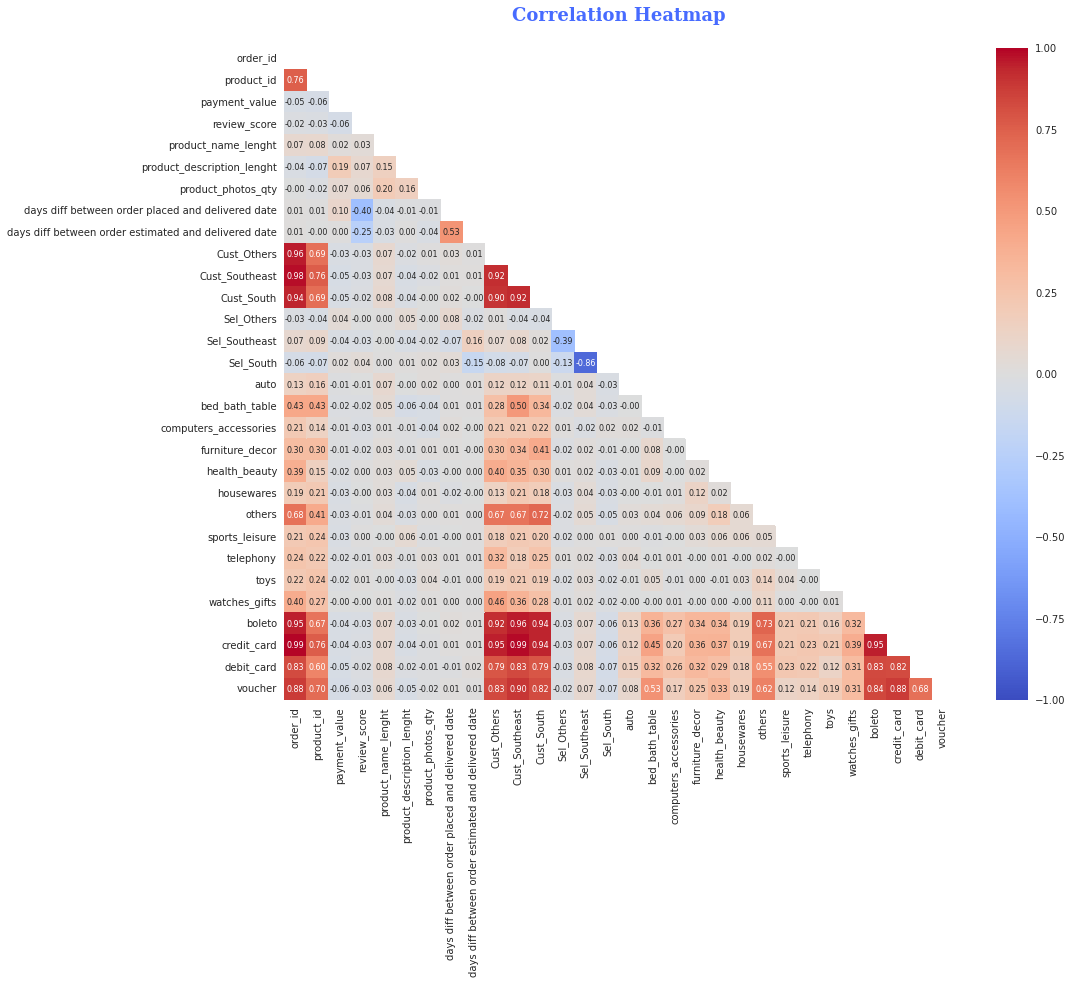

In [ ]:
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Correlation Heatmap\n", 
          fontdict=font_title)
plt.show()

There is strong relationship between the customers region and also between customer regions and payment method. There is a strong relationship between order count and payment method. So I decided to remove customer regions and payment methods. Apart from these relationsips there is also a strong relationship between Order counts and products order counts. I'm dropping product count.

In [ ]:
data = data.drop(columns = ['product_id','Cust_Others','Cust_Southeast',
                            'Cust_South','boleto','credit_card','debit_card','voucher'])

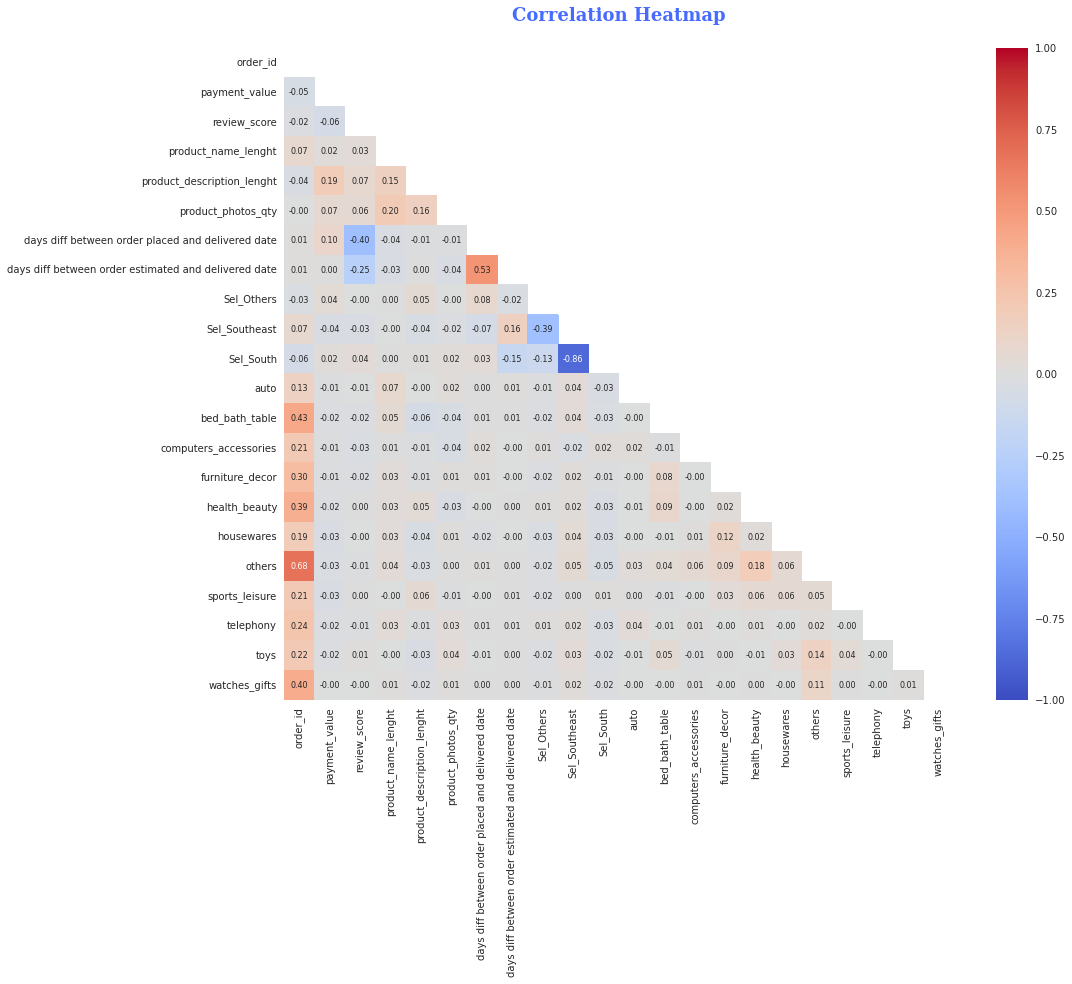

In [ ]:
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Correlation Heatmap\n", 
          fontdict=font_title)
plt.show()

## Clustering Algorithms and their implementation

Reference - [A Comprehensive Survey of Clustering Algorithms](https://link.springer.com/article/10.1007/s40745-015-0040-1)

The goal of cluster analysis is to partition the observations into groups (“clusters”) so that the pairwise dissimilarities between those assigned to the same cluster tend to be smaller than those in different clusters. 

Types


*   **Combinatorial Algorithms** - work directly on the observed data with no direct reference to an underlying probability model
*   **Mixture Modeling** - supposes that the data is an i.i.d sample from some population described by a probability density function
*   **Mode Seeking (bump hunters)** - take a nonparametric perspective, attempting to directly estimate distinct modes of the probability density function.


We will work with Combinatorial Algorithms to answer our question.

<a name="Section1.3"></a>

### K-Means Clustering

The K-means algorithm is one of the most popular iterative descent clustering algorithm. It is intended for situations in which all variables are of the **quantitative** type, and **squared Euclidean distance** is chosen as the dissimilarity measure.

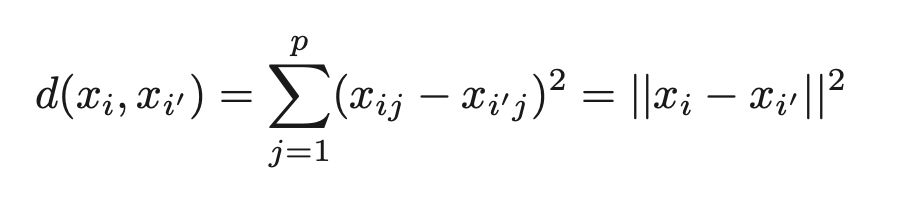





The k-means algorithm takes as input the number of clusters to generate, k, and a set of observation vectors to cluster. It returns a set of centroids, one for each of the k clusters. An observation vector is classified with the cluster number or centroid index of the centroid closest to it.

A vector v belongs to cluster i if it is closer to centroid i than any other centroids. If v belongs to i, we say centroid i is the dominating centroid of v. The k-means algorithm tries to minimize ***distortion***, which is defined as the sum of the squared distances between each observation vector and its dominating centroid. Each step of the k-means algorithm refines the choices of centroids to reduce distortion. The change in distortion is used as a stopping criterion: when the change is lower than a threshold, the k-means algorithm is not making sufficient progress and terminates. One can also define a maximum number of iterations.

There are multiple Evaluation Metric for K-Means. They calculate Goodness of Split. 



*   [Davies–Bouldin indicator](https://pyshark.com/davies-bouldin-index-for-k-means-clustering-evaluation-in-python/) - calculates the average similarity of each cluster with a cluster most similar to it.
*  [Dunn Index](https://pyshark.com/dunn-index-for-k-means-clustering-evaluation-using-python/) - calculated as a ratio of the smallest inter-cluster distance and the largest intra-cluster distance.
*   [Calinski-Harabasz Index](https://pyshark.com/calinski-harabasz-index-for-k-means-clustering-evaluation-using-python/) (Variance Ratio Criterion)- calculated as a ratio of the sum of inter-cluster dispersion and the sum of intra-cluster dispersion for all clusters
*   [Silhouette Index](https://ankitajhumu.medium.com/selecting-number-of-clusters-in-k-mean-clustering-d60a1f85d65b) - measure of how similar a data point is to its own cluster (cohesion) compared to other clusters (separation)


We will use above metric to calculate optimal number of K 





K-Means algorithm scales linearly with N. Hence complexity of K-Means O(n)

In [ ]:
data.head()

,order_id,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,days diff between order placed and delivered date,days diff between order estimated and delivered date,Sel_Others,Sel_Southeast,...,bed_bath_table,computers_accessories,furniture_decor,health_beauty,housewares,others,sports_leisure,telephony,toys,watches_gifts
seller_id,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,916.020000,3.666667,40.000000,849.000000,2.000000,10.666667,-16.333333,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
001cca7ae9ae17fb1caed9dfb1094831,192,202.367811,3.974249,35.828326,471.974249,1.789700,12.841202,-13.566524,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,0.0
002100f778ceb8431b7a1020ff7ab48f,50,42.327018,4.087719,55.157895,654.842105,1.000000,15.824561,-8.491228,0.0,1.0,...,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004c9cd9d87a3c30c522c48c4fc07416,143,155.210755,4.188679,56.270440,528.503145,1.056604,13.855346,-12.308176,0.0,1.0,...,159.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00720abe85ba0859807595bbf045a33b,13,119.938462,3.653846,43.576923,493.192308,2.230769,8.384615,-12.730769,0.0,1.0,...,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0


**Normalizing Data** - after normalizing data, we can calculate similarity more accurately.

In [ ]:
scaler = MinMaxScaler()

#### K- using elbow method

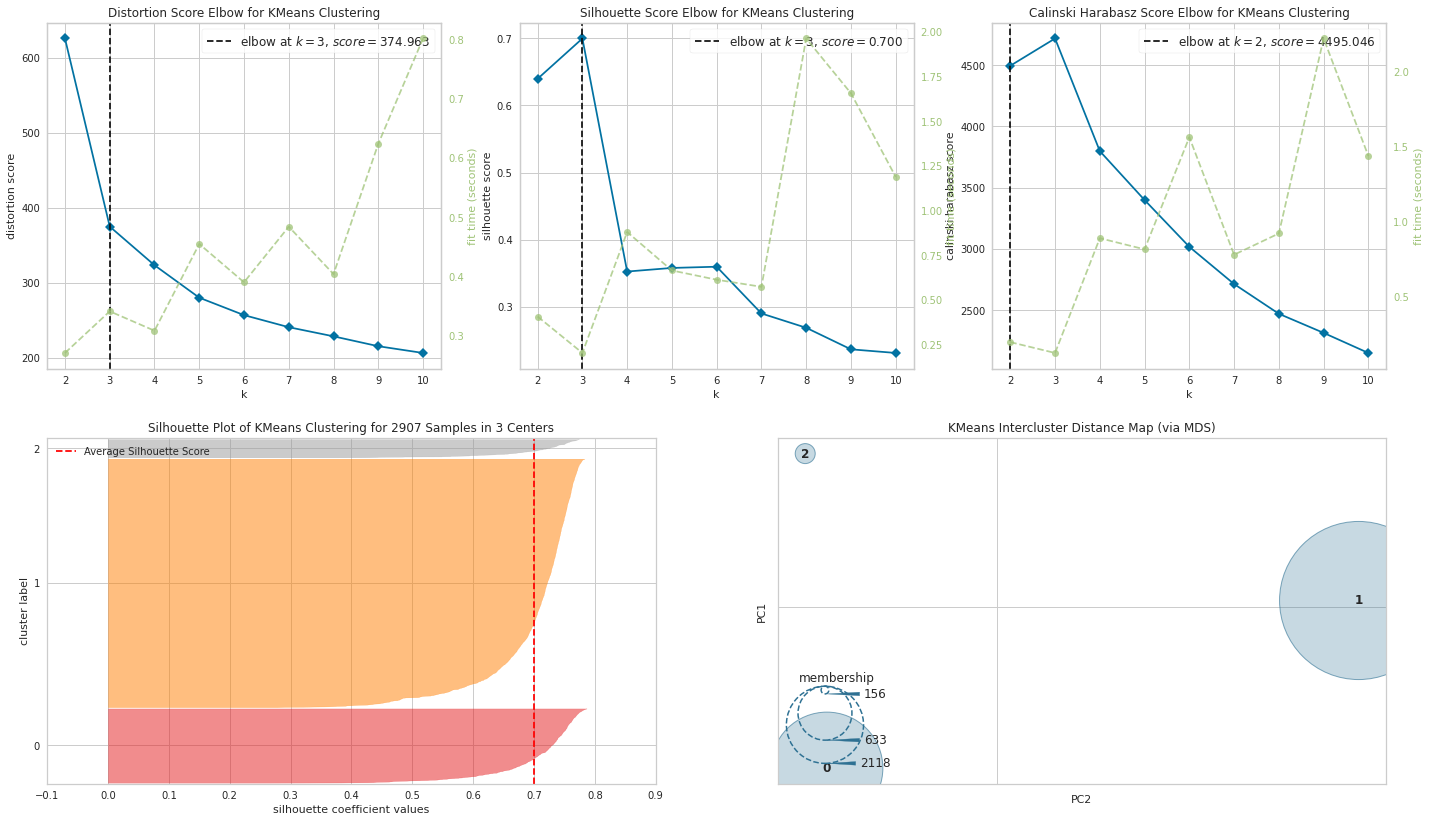

In [ ]:
# function to plot all graphs

def Kmeansplots(data):
    X = data.copy()

    # Making sure we select only numeric features
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                         'uint8']).columns)
    # Normalize data and transform 
    preprocessor = ColumnTransformer([
        ('scaler', scaler, numerical_features)])

    plt.figure(figsize=(24, 14));ax1 = plt.subplot(2,3,1);ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3);ax4 = plt.subplot(2,2,3);ax5 = plt.subplot(2,2,4)
    
    # plotting all evaluation metrics 

    # Reference - https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

    visual_grid1 = [
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='distortion',
                                      ax=ax1))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='silhouette',
                                      ax=ax2))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='calinski_harabasz',
                                      ax=ax3))]),'kelbowvisualizer')                    
                  ]

    i=0
    for viz in visual_grid1:
        viz[0].fit(X)
        if i==0:
          #Defining the best K by distortion method
          K = viz[0].named_steps['kelbowvisualizer'].elbow_value_ 
          i = i+1
        viz[0].named_steps[viz[1]].finalize()

    #Reference - https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
    visual_grid2 = [(Pipeline([("preprocessor", preprocessor),("silhouettevisualizer",
                                      SilhouetteVisualizer(KMeans(K,random_state=0),ax=ax4))]),
                                      'silhouettevisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("distancevisualizer",
                                      InterclusterDistance(KMeans(K,random_state=0),ax=ax5))]),
                                        'distancevisualizer')]
    for viz in visual_grid2:
      viz[0].fit(X)
      viz[0].named_steps[viz[1]].finalize()

    # KMeans Pipeline with best K
    kmeans_model = Pipeline([("preprocessor", preprocessor),
                            ("kmeans", KMeans(K,random_state=0))])
    kmeans_model.fit(X)
    # Kmeans labels
    kmeans_labels = kmeans_model.named_steps['kmeans'].labels_  
    X["kmeans_label"] = kmeans_labels

    return X

X_0 = Kmeansplots(data)


The ideal number of clusters, according to the 3 elbow approach, is 3. All of the registers in the Silhouette plots have a high silhouette coefficient, indicating that the clusters are dense. It is clear from the interdistance map that clusters are separated from one another.

In [ ]:
X_0.groupby(['kmeans_label']).agg({'kmeans_label':'count',  
                                   'Sel_Others':'sum',
                                   'Sel_Southeast':'sum',
                                   'Sel_South':'sum'})

,kmeans_label,Sel_Others,Sel_Southeast,Sel_South
kmeans_label,,,,
0,633,0.0,0.0,633.0
1,2118,0.0,2118.0,0.0
2,156,156.0,0.0,0.0


As evidenced by the groupby result above, the issue is that the cluster was essentially determined by the sellers region. No information is thus valuable. This prompts us to eliminate the dataset's columns and perform the analysis again.

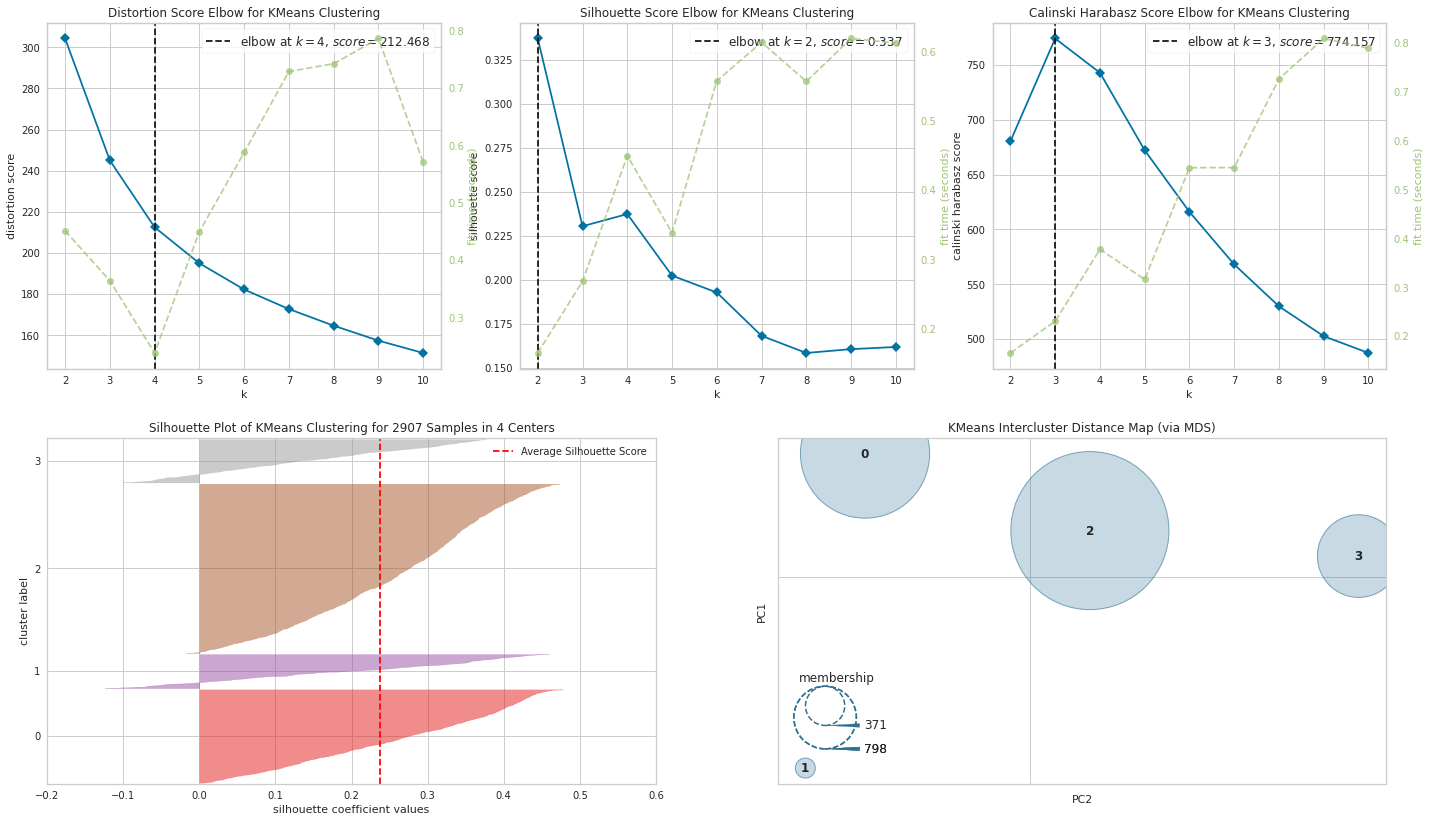

In [ ]:
data_1 = data.drop(columns=['Sel_Others','Sel_South','Sel_Southeast'])
X_1= Kmeansplots(data_1)


There are 4 clusters for the elbow curve with distortion method. The elbow curvature with the silhouette and Calinski Harabasz are different in this case. Although 2 clusters is the maximum value for the Silhouette, 4 is a local maximum, and for the Calinski Harabasz, 4 is the second-best choice. Therefore let's continue using 4 clusters. 

This is not the ideal outcome, as the Silhouette plot reveals negative values for various registers in clusters 0, 1, and 2. Furthermore, there is a low average silhouette coeficient. When the vendors' geographic regions were taken into account, there is a strong 0.7, but that is not helpful.

In [ ]:
X_1.groupby('kmeans_label').agg({'order_id':'count'})

,order_id
kmeans_label,
0,798
1,292
2,1446
3,371


The largest group is the cluster 3 followed by cluster 0. 

Now, let's analyse our result in visual form.

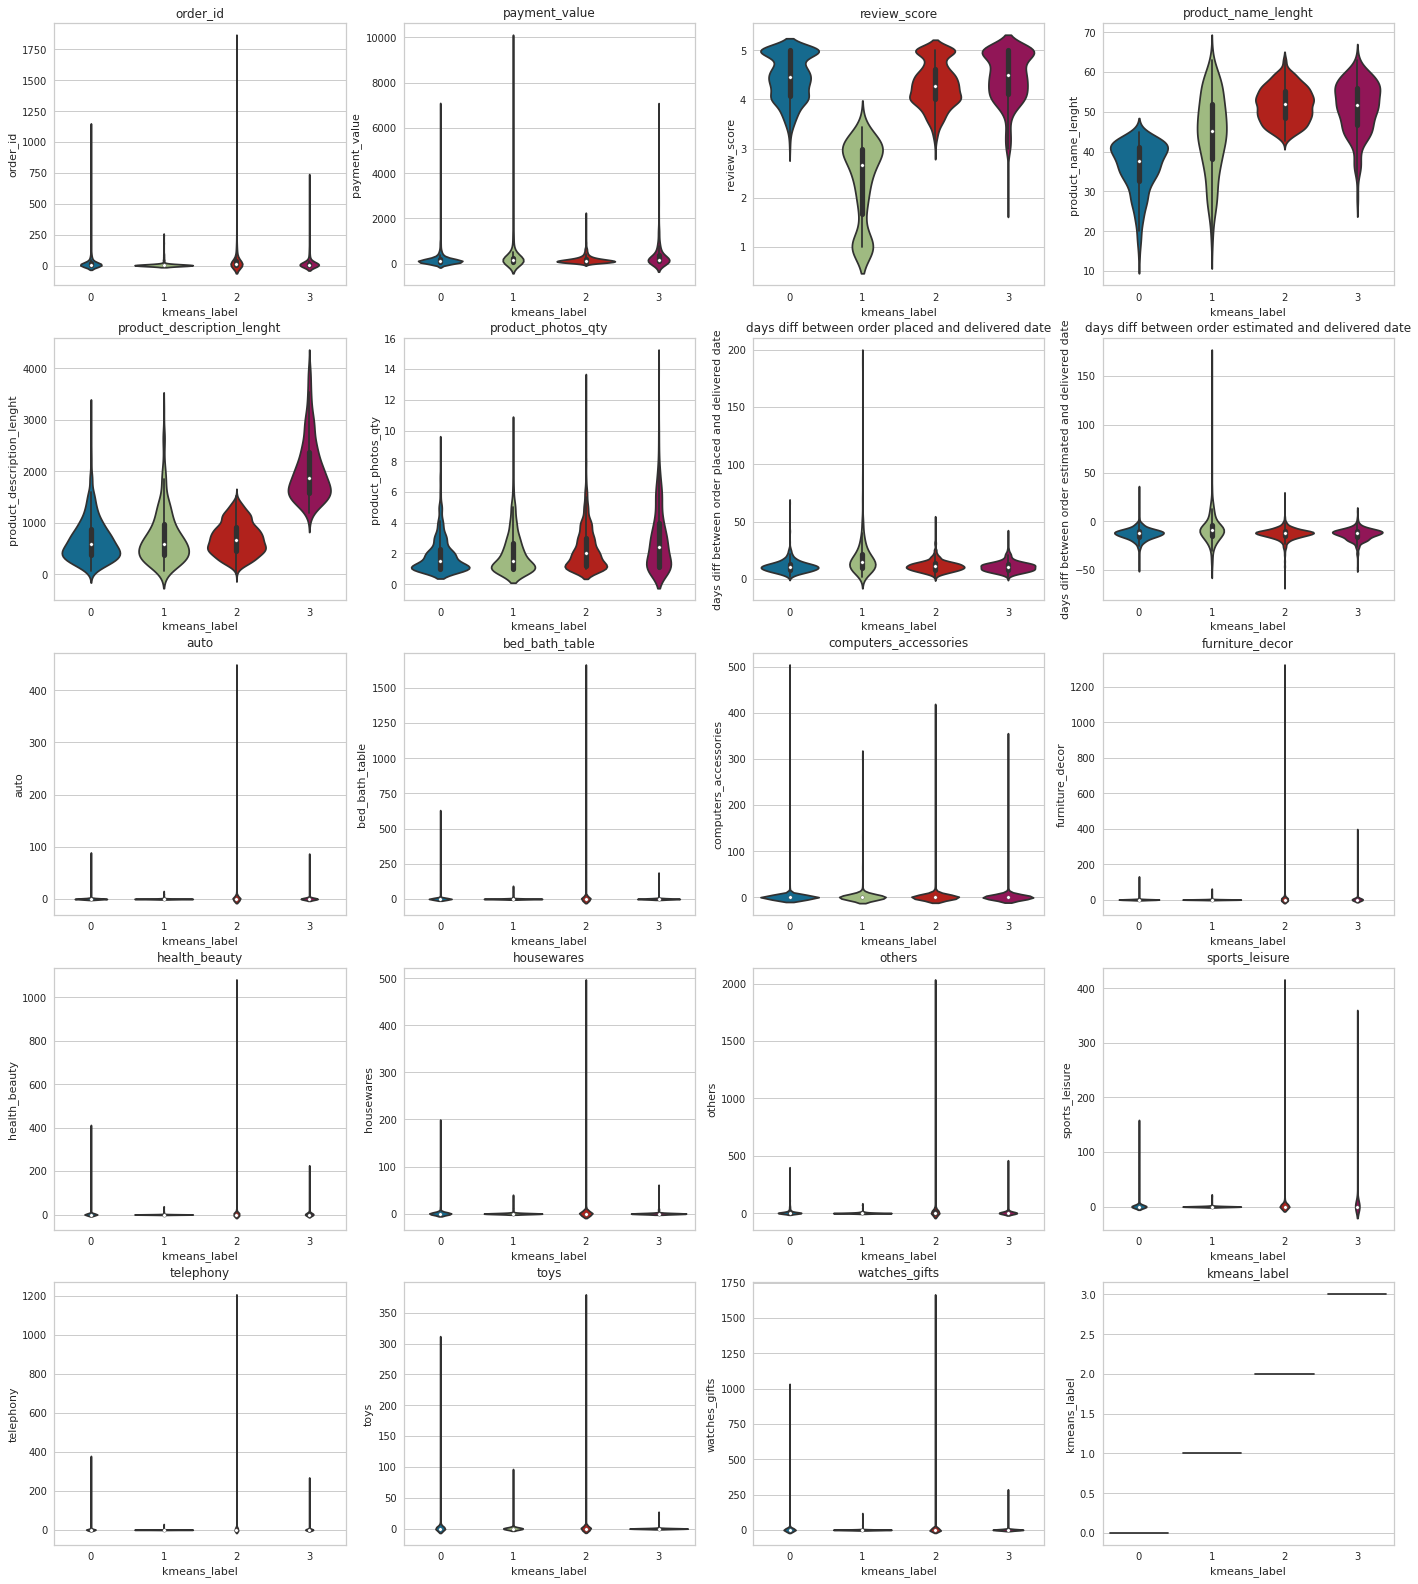

In [ ]:
aux = X_1.columns
fig = plt.figure(figsize=(24,28))
a = 0; b=0
for i in aux:
    axes = plt.subplot2grid((5,4),(a,b))
    sns.violinplot(x = X_1['kmeans_label'],y = X_1[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('kmeans_label')  
    b = b+1
    if b>=4:
      b = 0
      a = a+1

The mean and median number of sales for each category and cluster are represented by the violin plots above. It appears that there is no link between the cluster and the product categories. Every cluster has the same median number of sales for every category and every cluster has the same mean number of sales for every category. In each cluster, it indicates that at least 50% of the vendors did not complete a sale in those categories. The violin plots support all of this. The vast majority of points did not make a single sale at the category since all violins are thick at the base and practically straight as they rise. 

Hence, Let's drop all the product categories columns and analyse with rest columns.

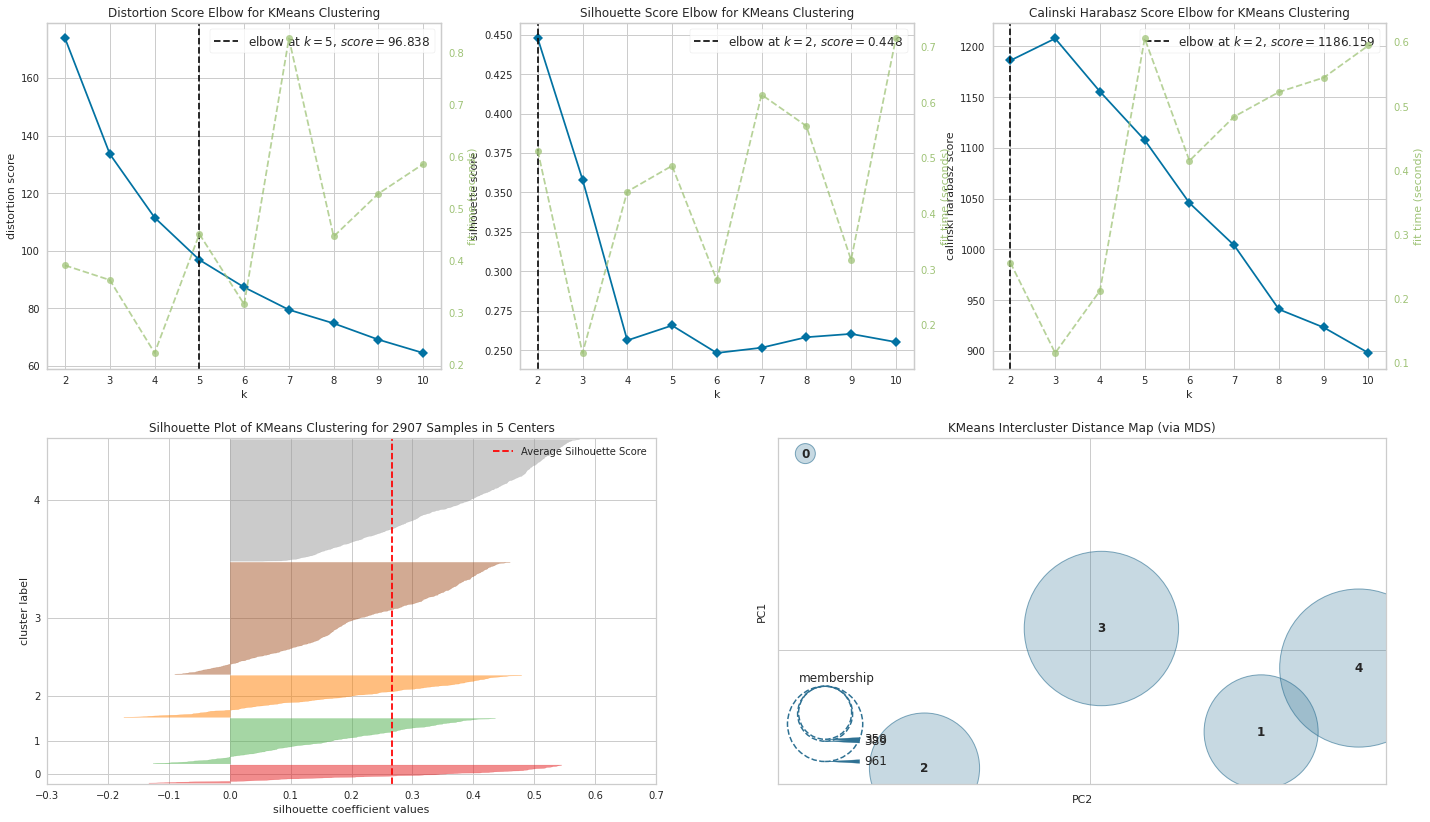

In [ ]:
data_1_reduced = data_1[['order_id','payment_value','review_score',
                        'product_description_lenght','product_photos_qty',
                         'days diff between order placed and delivered date','days diff between order estimated and delivered date']]

X_1_reduced= Kmeansplots(data_1_reduced)


Now, we got 5 clusters, instead of previous 3 and 4 using distortion method. Silhouette and Harabasz gave us 2 cluster. 5 is local maximum for both of them. Let's processed with the 5 clusters for now. 

In [ ]:
X_1_reduced.groupby('kmeans_label').agg({'order_id':['count','sum','median'],
                                         'payment_value':['median', 'min', 'max'],
                                         'review_score':'mean',
                                         'product_description_lenght':'median',
                                         'product_photos_qty':'mean',
                                         'days diff between order placed and delivered date':'mean',
                                         'days diff between order estimated and delivered date': 'mean'})

order_id               payment_value                          \
                count    sum median        median        min          max   
kmeans_label                                                                
0                 156    460    2.0    165.870000   8.563333  9687.936000   
1                 389  12980    8.0    149.149320  19.210000  3602.470000   
2                 358   9058    6.0    160.393698  21.510588  6726.660000   
3                 961  55080   11.0    139.703077  21.280000  2688.971111   
4                1043  18207    5.0    119.451971   9.645000  6929.310000   

             review_score product_description_lenght product_photos_qty  \
                     mean                     median               mean   
kmeans_label                                                              
0                1.707221                 625.125000           2.063660   
1                4.478681                 812.000000           4.826494   
2                4.420836                1922.636364           2.340862   
3                3.762400                 589.000000           1.863017   
4                4.673945                 618.642857           1.663808   

             days diff between order placed and delivered date  \
                                                          mean   
kmeans_label                                                     
0                                                    21.482152   
1                                                    11.155843   
2                                                    11.091341   
3                                                    13.177839   
4                                                    10.215751   

             days diff between order estimated and delivered date  
                                                             mean  
kmeans_label                                                       
0                                                     -5.343265    
1                                                    -13.231266    
2                                                    -13.383684    
3                                                    -11.783571    
4                                                    -13.198912

Note, here count of order id represents sellers count, and Sum represents total order in cluster.

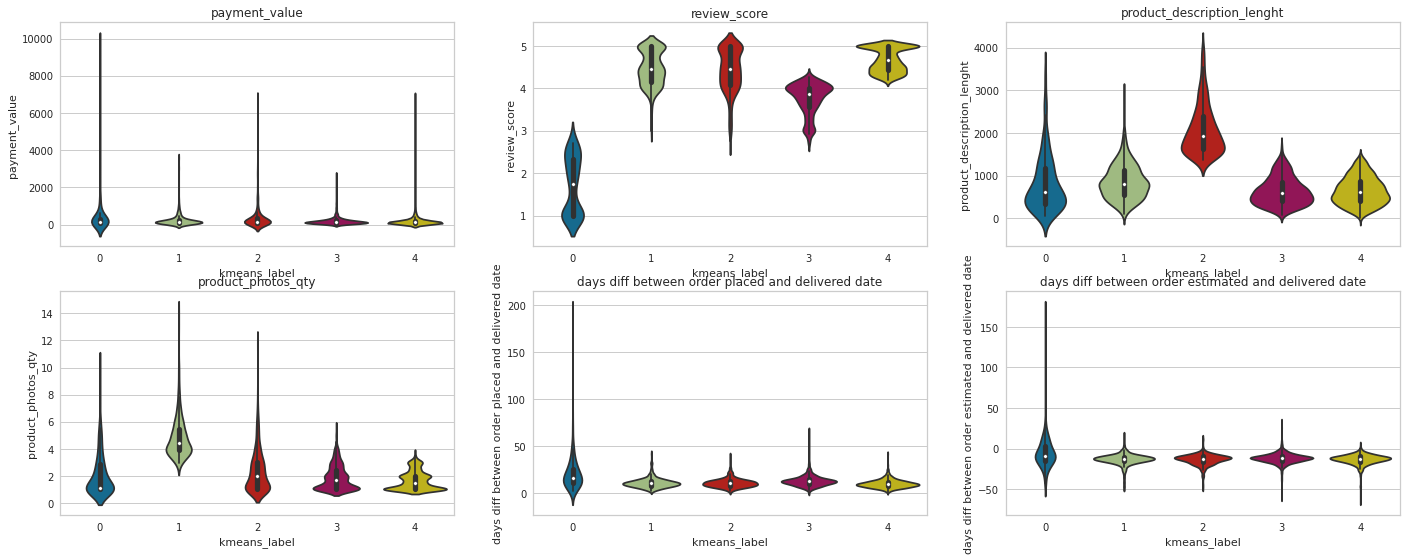

In [ ]:
columns = ['payment_value', 'review_score', 'product_description_lenght','product_photos_qty','days diff between order placed and delivered date','days diff between order estimated and delivered date']
n_plot = 331
fig = plt.figure(figsize=(24,14))
for i in columns:
  if i!='kmeans_label':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_1_reduced['kmeans_label'],y = X_1_reduced[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('kmeans_label')
    n_plot = n_plot+1

Cluster 0 : In cluster 0, we have almost negligible orders comapred with other clusters. However, for few products in cluster 0 payment value is low, with some exceptions. They also received very low reviews as most of the sellers not able to deliver prodcuts on time, which can be seen in the 'days between estimated and delivered date'. Most of the sellers in this cluster has posted very less photos (median=1.13) and also very short product description, about 625 median words. It is possible to conclude that this cluster gathered the non-professionals online sellers. People that only needed to sell one item once and never had to do it again.

Cluster 1: This cluster has the third-lowest orders. In this cluster, the median payment value is lowest. The majority of the sellers in this cluster are able to complete orders on time or before the real delivery date, with a median value of less than 0. Sellers in this cluster have excellent ratings, with a median score of 4.5. Sellers in this cluster have written good descriptions and submitted the most product photographs. It is possible to conclude that this cluster gatherd sellers who offer cheap or low-quality goods for sale.

Cluster 2: Sellers in this cluster has sold average # products (Among our data) not too much, not too less. Also, median value for the sales in this cluster is about to 161 Brazilian Real. Sellers in this cluster wrote most lengthly descriptions and have added median 2 photos. Sellers in this cluster are able to deliver items before expected delivery date and hence received good reviews with median 4.46.

Cluster 3: This is the second largest group of sellers (961 sellers). Few Sellers in this group managed to sell products to 1.7k+ customers. However, these sellers sells very low quality and cheap products, median value of payment is lowest in this cluster and it is only 139 Brazilian Real. Sellers in this cluster do not like to advertise thier products as their product description length is lowest among all and also post median 1.66 photos. Sellers in this cluster has so so reviews as many of them received delivery after estimated date.

Cluster 4: This cluster is largest group of sellers (1043 sellers). However, they didn't able to attract many customers. Sellers in this group have very good feedback from customers (median 4.7) as amlost all of the sellers able to deliver products before estimated delivery date. Sellers in this cluster posted least photo around 1.5 photos and also not wrote big descriptions. These could be the reason sellers in this group not able to attrack more customers. 

#### K=2

Let's try to visualize data for K=2 as well as K=7. and see what results we get.

In [ ]:
X_KMeans = data_1_reduced.copy()

def KMeans_method(data, K):
    # Making sure we select only numeric features
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                            'uint8']).columns)
    # Normalize data and transform 
    preprocessor = ColumnTransformer([
            ('scaler', scaler, numerical_features)])

    kmeans_model = Pipeline([("preprocessor", preprocessor),
                                ("kmeans", KMeans(K, random_state=0))])
    kmeans_model.fit(data)
    kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
    return kmeans_labels

In [ ]:
X_KMeans['labels'] = KMeans_method(X_KMeans, 2)
X_KMeans.groupby('labels').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_lenght':'median',
                                         'product_photos_qty':'median',
                                         'days diff between order placed and delivered date':'median',
                                         'days diff between order estimated and delivered date':'median'               
                                                          })

order_id        payment_value review_score product_description_lenght  \
          count median        median       median                     median   
labels                                                                         
0           364    3.0    162.998118     3.000000                 634.200000   
1          2543    8.0    134.097647     4.363636                 720.888889   

       product_photos_qty days diff between order placed and delivered date  \
                   median                                            median   
labels                                                                        
0                1.654102                                         14.311962   
1                1.911765                                         10.720307   

       days diff between order estimated and delivered date  
                                                     median  
labels                                                       
0                                               -9.557692    
1                                              -12.162791

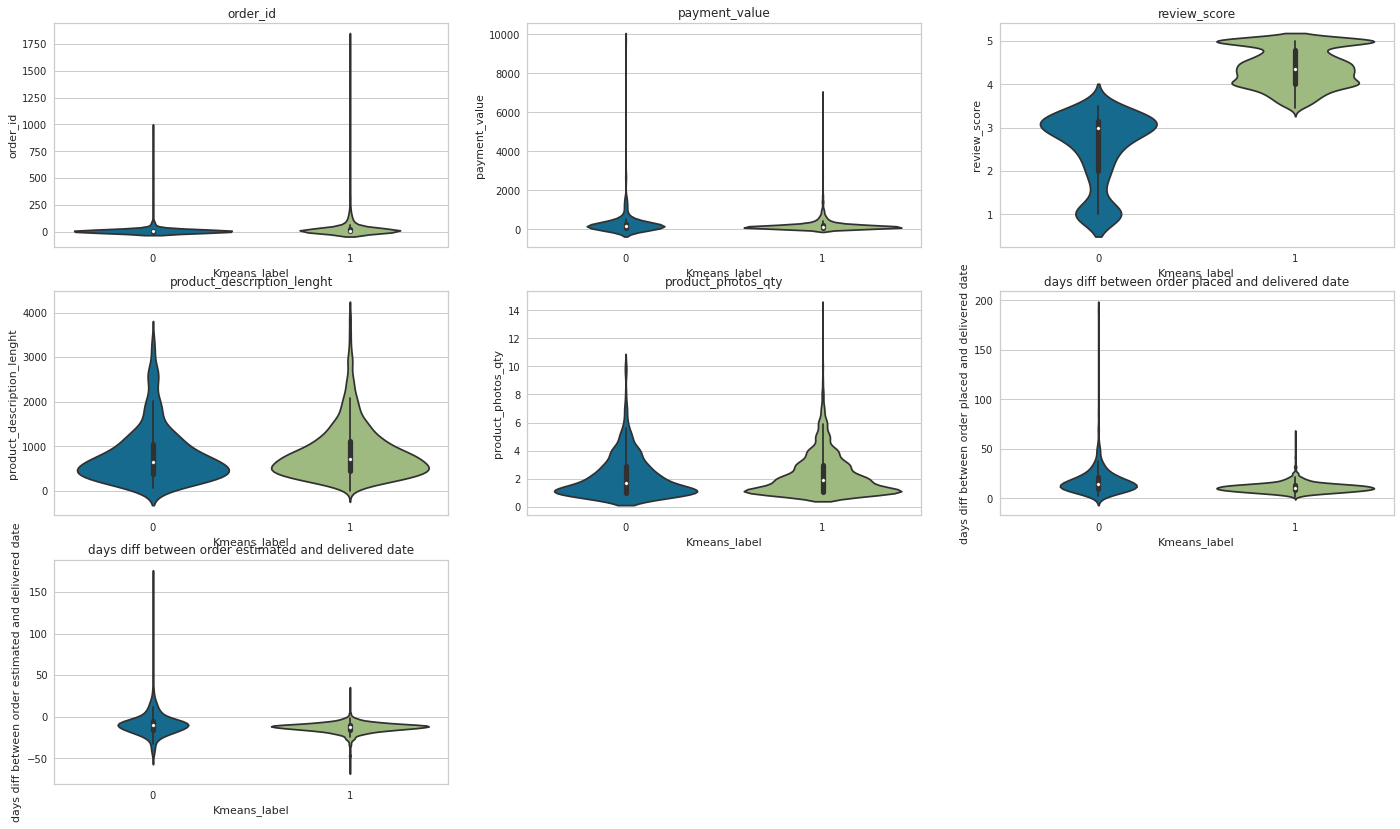

In [ ]:
n_plot = 331
fig = plt.figure(figsize=(24,14))
for i in X_KMeans:
  if i!='labels':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_KMeans['labels'],y = X_KMeans[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('Kmeans_label')
    n_plot = n_plot+1

Cluster 0: There are 364 sellers in this cluster but they made median 3 orders with few exceptions. Their median payment value is higher than the cluster 1 sellers but they received low reviews as many of them are not able to deliver orders on time. There is not too much difference between how much photos they have posted and length of description.  

Cluster 1: Around 87% sellers are in this cluster. They made median 8 orders with few exceptions. Their median payment value is also higher than the cluster 1 sellers and have received good reviews as most of them are able to deliver orders on or before expected delivery date.

#### K=7

In [ ]:
X_KMeans['labels'] = KMeans_method(X_KMeans, 7)
X_KMeans.groupby('labels').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_lenght':'median',
                                         'product_photos_qty':'median',
                                         'days diff between order placed and delivered date':'median',
                                         'days diff between order estimated and delivered date':'median'               
                                                          })

order_id        payment_value review_score product_description_lenght  \
          count median        median       median                     median   
labels                                                                         
0           350    7.0    153.012721     4.438447                 804.105820   
1           871   16.0    131.246271     4.000000                 535.750000   
2           279    5.0    161.488750     3.000000                 633.400000   
3           155    5.0    185.880000     4.500000                2480.166667   
4           680    3.0    108.639286     4.930952                 546.519231   
5           104    1.0    167.500000     1.000000                 590.750000   
6           468    8.0    149.175667     4.428571                1350.000000   

       product_photos_qty days diff between order placed and delivered date  \
                   median                                            median   
labels                                                                        
0                4.674575                                         10.533592   
1                1.555556                                         12.000000   
2                1.916667                                         13.666667   
3                2.500000                                         11.000000   
4                1.500000                                          9.000000   
5                1.000000                                         18.000000   
6                1.634938                                         10.432471   

       days diff between order estimated and delivered date  
                                                     median  
labels                                                       
0                                              -12.805556    
1                                              -11.750000    
2                                              -10.333333    
3                                              -12.285714    
4                                              -12.741667    
5                                               -6.500000    
6                                              -12.200000

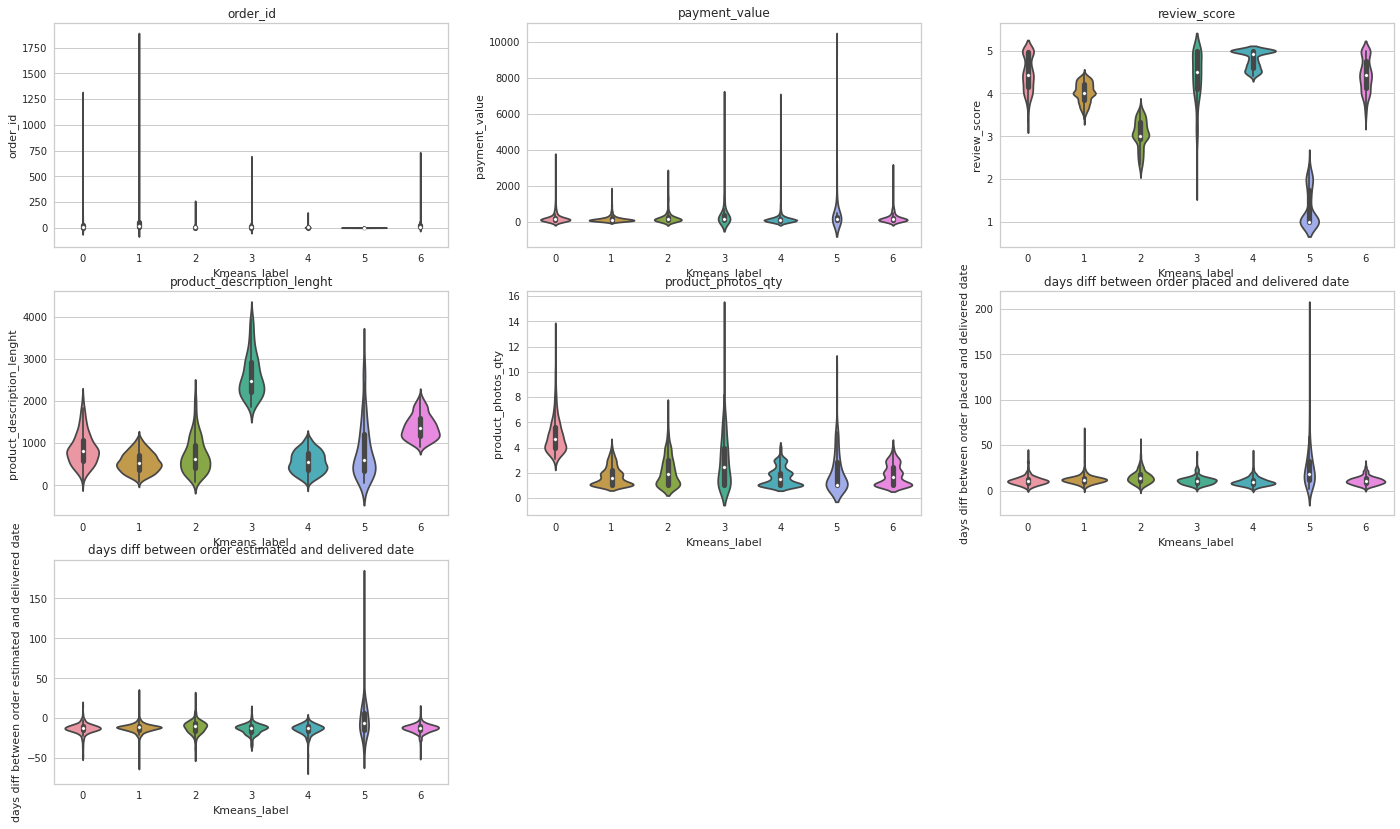

In [ ]:
n_plot = 331
fig = plt.figure(figsize=(24,14))
for i in X_KMeans:
  if i!='labels':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_KMeans['labels'],y = X_KMeans[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('Kmeans_label')
    n_plot = n_plot+1

Ahh.. with 7 clusters looks amazing. 

Cluster 0:  There are 683 sellers in cluster 0 (second highest) and they were able to make 109 brazilian Real per order. Sellers in this group has delivered orders very fast. Mostly all of them delivered orders before extimated delivery date and hence received very good reviews. Sellers in this cluster wrote short descriptions and has posted median 1.5  photos. Sellers in this cluster are able to make very few orders. Looks like they are one time sellers.

Cluster 1: There are 467 sellers in this cluster and they were able to make median 149 from orders. They are able to make median 8 orders and have received reviews in range from 3 to 5 as most of them not able to deliver orders on time. Sellers in this cluster wrote lengthy descriptions and posted median 1.6 photos. 

Cluster 2: There are 274 sellers in this cluster and they were able to make median 162 from orders. But they were able to make very few orders around median 5 as some of them do not have good history of delivering products on time and some of them not posted photos at all. Also sellers in this cluster wrote avg length description.

Cluster 3: There are only 152 sellers in this group (second lowest) but these are the sellers who able to sold heighest payment value products. Their median payment value is 189 Brazilian Real. Sellers in this cluster has written lengthy description with around 2500 words and posted median 2.6 photos. sellers in this cluster have received reviews from  1.4 to 5 and above with median value of 4.5

Cluster 4: This cluster contains highest number of the sellers and they are able to make highest median orders around 16. They also received good median reviews 4 as almost all of them able to deliver product before expected delivery date. Sellers in this cluster wrote short description and has posted median 1.5 photos.

Cluster 5: This cluster contains very few sellers (lowest number of sellers) and able to make median 1 order. They made orders with median value of 590. Sellers in this group are not good with delivering products on time and as a result they received bad reviews. Also, few sellers in this cluster has not written description of product nor posted photos. 

Cluster 6: This cluster 348 sellers and were able to make 7 median orders with median payment value of 153. Sellers in this cluster has received same reviews and able to make similar number of orders as in cluster 2. Sellers in cluster 6 wrote similar length description as in cluster 2 however, sellers in this cluster has posted more photos than in cluster 2. 

As per my analysis, sellers in cluster 4 performed well compared with rest of sellers. We can conclude from this, 2 photos, avg descrition leght around 500 words and good delivery service is a key for successful business on the Olist.

#### K-Means Clustering Result:

After analysing results from all 3 'K' values, I feel the results from K=5 (using Elbow method) are more useful. However, K=7 gave us more detailed results. However, they seem to overfit the data and do not add much additional information to the information we got from K=5. 

*italicized text*<a name="Section1.4"></a>

### hierarchical/Ward Clustering

The results of applying K-means or K-medoids clustering algorithms de- pend on the choice for the number of clusters to be searched and a starting configuration assignment. In contrast, hierarchical clustering methods do not require such specifications. Instead, they require the user to specify a measure of dissimilarity between (disjoint) groups of observations, based on the pairwise dissimilarities among the observations in the two groups. As the name suggests, they produce hierarchical representations in which the clusters at each level of the hierarchy are created by merging clusters at the next lower level. At the lowest level, each cluster contains a single observation. At the highest level there is only one cluster containing all of the data.

*   agglomerative (bottom-up) - Pair chosen for merging consist of the two groups with the smallest intergroup dissimilarity.
*   divisive (top-down) - Split is chosen to produce two new groups with the largest between-group dissimilarity.



We will use the last datafrmae (data_1_reduced) for our analysis.

Reference: https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

#### Euclidean Distance

** straight line distance**

Formula - 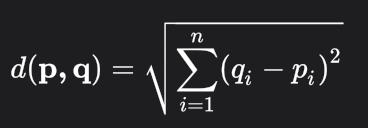

First, let's plot Dendogram using Ward method and eucleidean distance

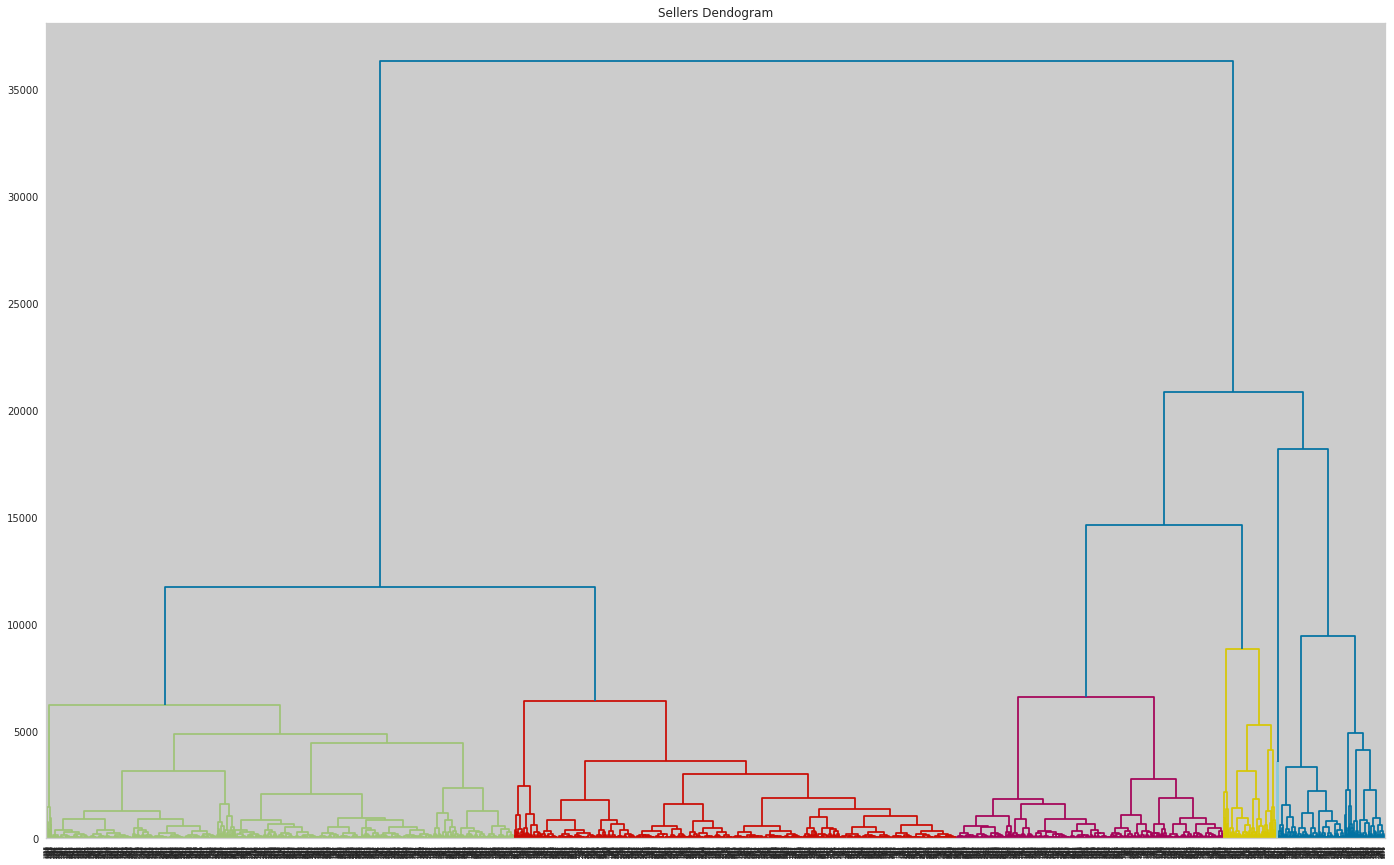

In [ ]:
plt.figure(figsize=(24, 15))  
plt.title("Sellers Dendogram")
link = shc.linkage(data_1_reduced, method='ward',metric='euclidean')
dend = shc.dendrogram(link, color_threshold=11000)  

We set the threshould of 11000 on a hunch, by visually inspecting the dendogram. As a result, we got 6 clusters. Two of them are huge in members and one is ridiculously small.

In [ ]:
X_hier = data_1_reduced.copy()
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
agrup = cluster.fit_predict(X_hier) 
X_hier['labels'] = agrup
X_hier.groupby('labels').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_lenght':'median',
                                         'product_photos_qty':'median',
                                         'days diff between order placed and delivered date':'median',
                                         'days diff between order estimated and delivered date':'median'               
                                                          })

order_id        payment_value review_score product_description_lenght  \
          count median        median       median                     median   
labels                                                                         
0           231    5.0    190.294543     4.416667                2237.928571   
1           116    5.0    954.790000     4.225000                1233.032632   
2           960    5.0    123.418124     4.222222                 360.000000   
3             3    1.0   6929.310000     5.000000                1748.266667   
4           579    7.0    141.314865     4.333333                1223.000000   
5          1018    9.0    124.201042     4.260819                 721.109213   

       product_photos_qty days diff between order placed and delivered date  \
                   median                                            median   
labels                                                                        
0                2.000000                                         11.000000   
1                2.300905                                         13.226190   
2                1.600000                                         11.000000   
3                2.000000                                         17.000000   
4                2.000000                                         10.709091   
5                1.888370                                         11.000000   

       days diff between order estimated and delivered date  
                                                     median  
labels                                                       
0                                              -12.195652    
1                                              -13.000000    
2                                              -12.000000    
3                                               -6.266667    
4                                              -12.200000    
5                                              -11.799716

Wow! we got 6 clusters and look at them how different are they from the K-means clusters. Let's visualize them for better understanding.

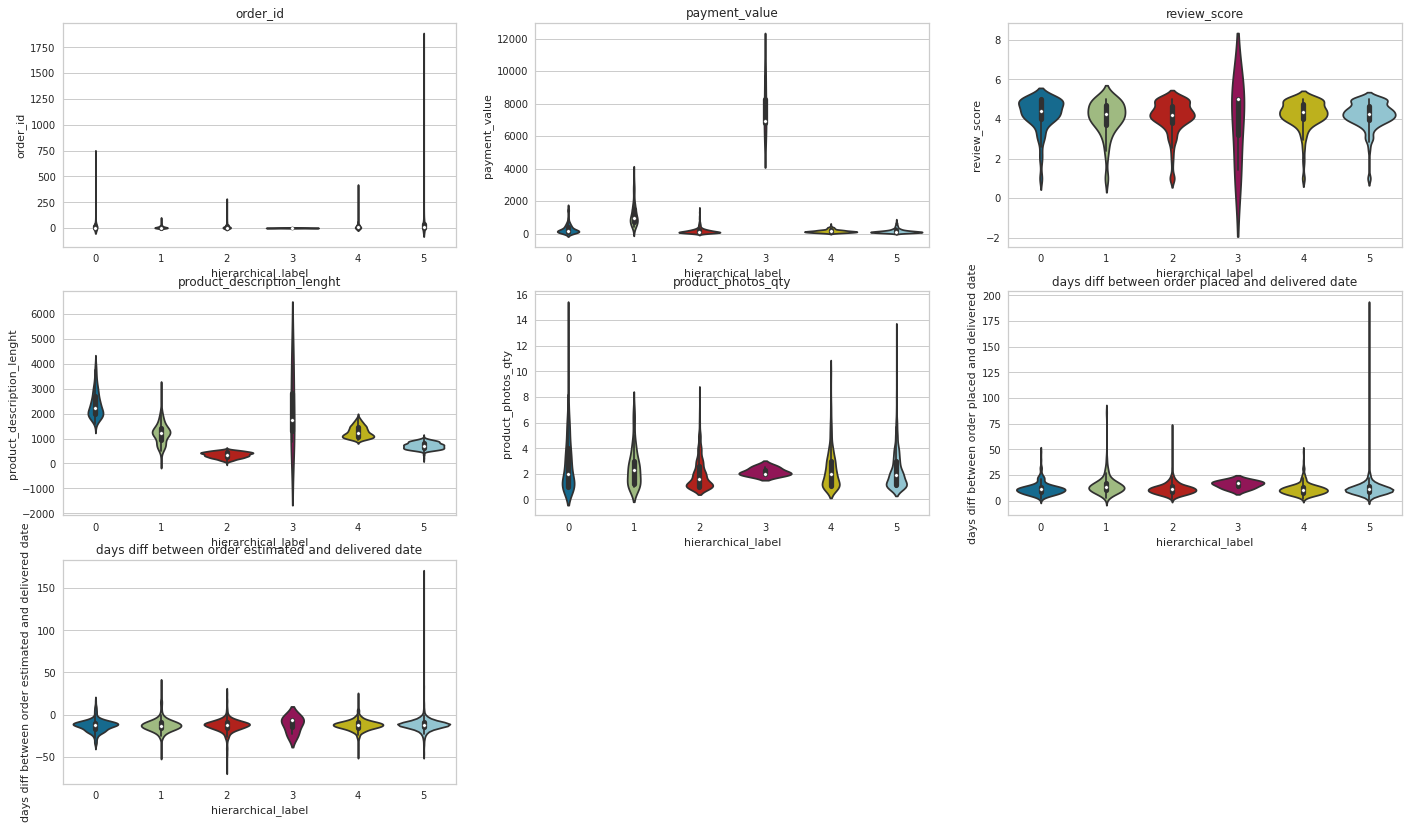

In [ ]:
n_plot = 331
fig = plt.figure(figsize=(24,14))
for i in X_hier:
  if i!='labels':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_hier['labels'],y = X_hier[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('hierarchical_label')
    n_plot = n_plot+1


Cluster 0: It has around 130 sellers in it and few members able to sold good quantity of products. However payment value for these products is very low and median payment value is 190 Brazilian Real. Sellers in this cluster wrote good legth of description for product with around 2K median words and has posted median 2 photos. Also, sellers able to deliver orders before estimated delivery day with very few exceptions. 

Cluster 1: This is second least cluster with sellers and able to sold very few orders. However, median price of products they sold is second heighest in all cluster and is about median 954 Brazilian Real. Sellers in this cluster wrote less descriptive description of prodcut and has posted median 2 photos. Sellers in this cluster receives good review as many of them able to deliver products before expected delivery date.

Cluster 2: This cluster contains second most sellers and they were able to sell 300 median orders. Sellers in this group sell cheapest products with median value of 123 Brazilian Real. Sellers in this cluster wrote very short description of products and has posted median 1.5 photos per product. Most of the sellers able to deliver orders before estimated delivery date and hence received good reviews.

Cluster 3: This cluster contains only 3 sellers and they were able to sold very few products, however products they sold have heighest median value 7000 Brazilian Real. Some of these sellers has not received good reviews as they were not able to deliver product on the time. Also, few sellers in this cluster wrote lenghtly description and few has not written at all. They have posted median 2 photos of products. Sellers in this group looks like one time sellers.

Cluster 4: Cluster 4 and 5 are almost same with little exception. Sellers in this cluster are selling low price prodcuts and able to deliver them before expected delivery date and hence received good reviews. Sellers in this cluster posted about the 2 photos with exception and wrote around 1000 words median description.

Cluster 5: Cluster 5 is similar to cluster 4 with some outliers.

#### Mahalanobis Distance

Find the distance between two points as a form of t-score. The Mahalanobis distance also takes normalisation and dispersion of the data into account.
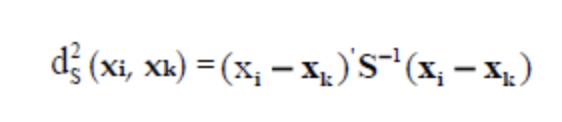

It is useful for non-spherical-shaped distribution, even if points A and B have the same Euclidean distance from point X, it’s distribution might not be equally distributed.

The Mahalanobis distance measures distance relative to the centroid — a base or central point which can be thought of as an overall mean for multivariate data. The centroid is a point in multivariate space where all means from all variables intersect. The larger the MD, the further away from the centroid the data point is. Mahalanobis distance accounts for how correlated the variables are to one another.

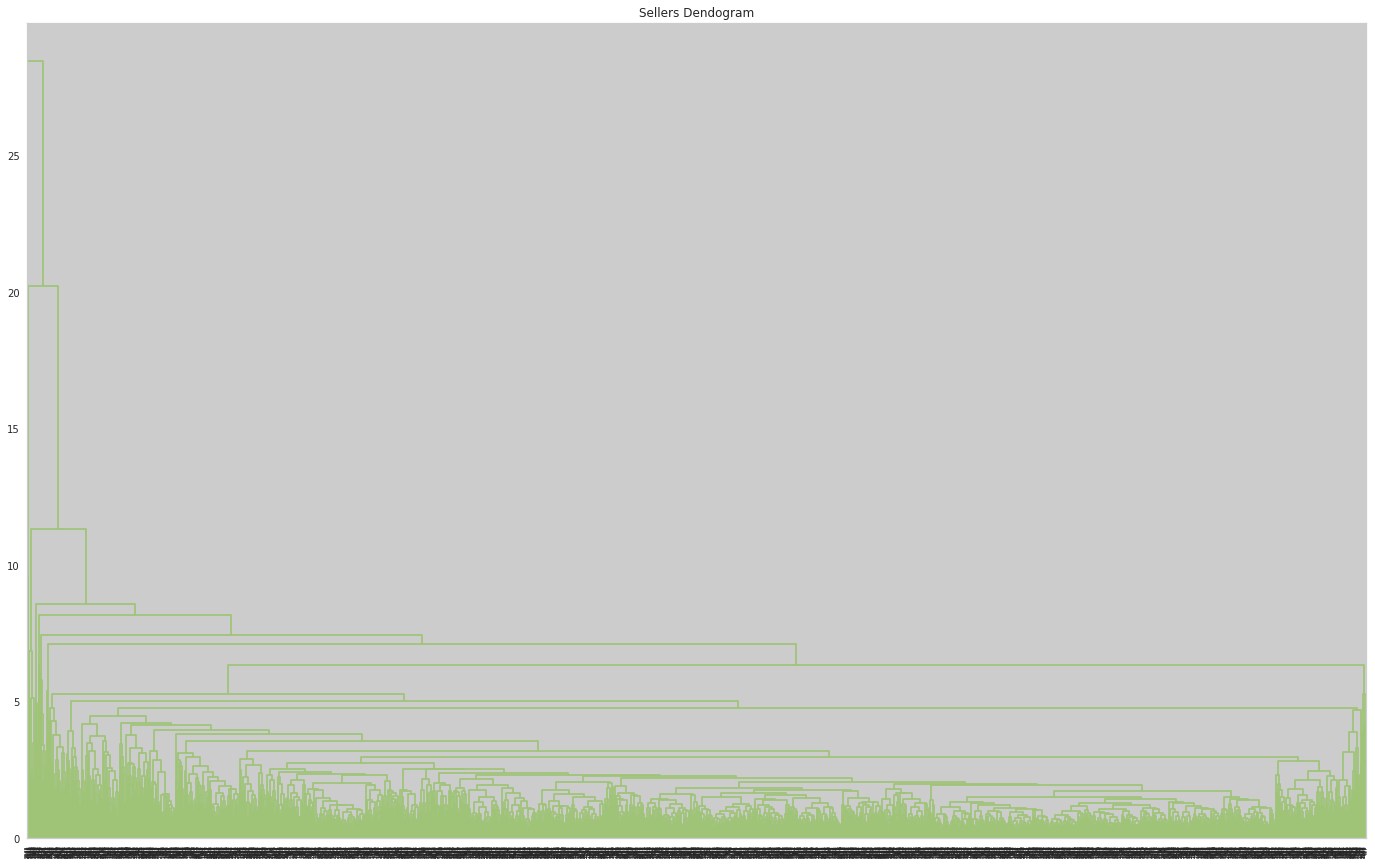

In [ ]:
plt.figure(figsize=(24, 15))  
plt.title("Sellers Dendogram")
link = shc.linkage(data_1_reduced, method='average',metric='Mahalanobis')
dend = shc.dendrogram(link, color_threshold=11000)  

In [ ]:
X_hier = data_1_reduced.copy()
cluster = AgglomerativeClustering(n_clusters=6, affinity='Mahalanobis', linkage='average')
agrup = cluster.fit_predict(X_hier) 
X_hier['labels'] = agrup
X_hier.groupby('labels').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_lenght':'median',
                                         'product_photos_qty':'median',
                                         'days diff between order placed and delivered date':'median',
                                         'days diff between order estimated and delivered date':'median'               
                                                          })

order_id         payment_value review_score product_description_lenght  \
          count  median        median       median                     median   
labels                                                                          
0          2882     7.0    135.894375     4.277778                 709.000000   
1            15  1126.0    141.334462     4.067916                 696.476582   
2             2     1.0   6827.985000     5.000000                2414.500000   
3             1     1.0     55.950000     1.000000                 966.000000   
4             1     4.0   9687.936000     1.400000                1748.266667   
5             6     1.0    165.045000     1.000000                 657.000000   

       product_photos_qty days diff between order placed and delivered date  \
                   median                                            median   
labels                                                                        
0                1.888889                                         11.000000   
1                1.585470                                         12.595661   
2                2.000000                                         15.500000   
3                3.000000                                        190.000000   
4                2.533333                                         17.000000   
5                1.000000                                         67.833333   

       days diff between order estimated and delivered date  
                                                     median  
labels                                                       
0                                              -12.000000    
1                                              -11.130374    
2                                              -14.500000    
3                                              167.000000    
4                                               -6.266667    
5                                               30.000000

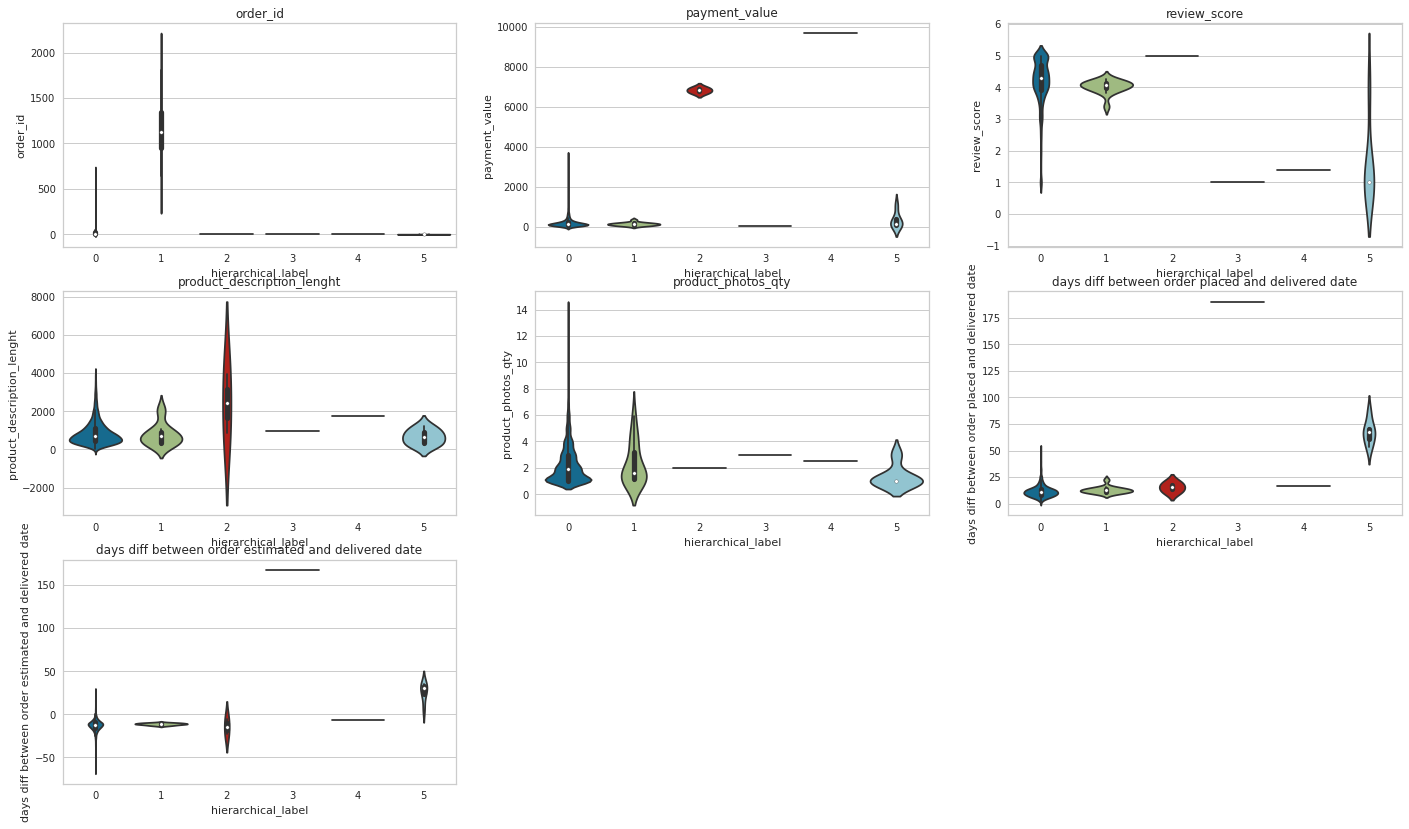

In [ ]:
n_plot = 331
fig = plt.figure(figsize=(24,14))
for i in X_hier:
  if i!='labels':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_hier['labels'],y = X_hier[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('hierarchical_label')
    n_plot = n_plot+1


Mahalanobis distance not able to help us to create a appropriate cluster. Reason behind this, it's calculate distance relative to centroid and it grouped all points which are near in one cluster and outliers in other cluster.

#### cosine

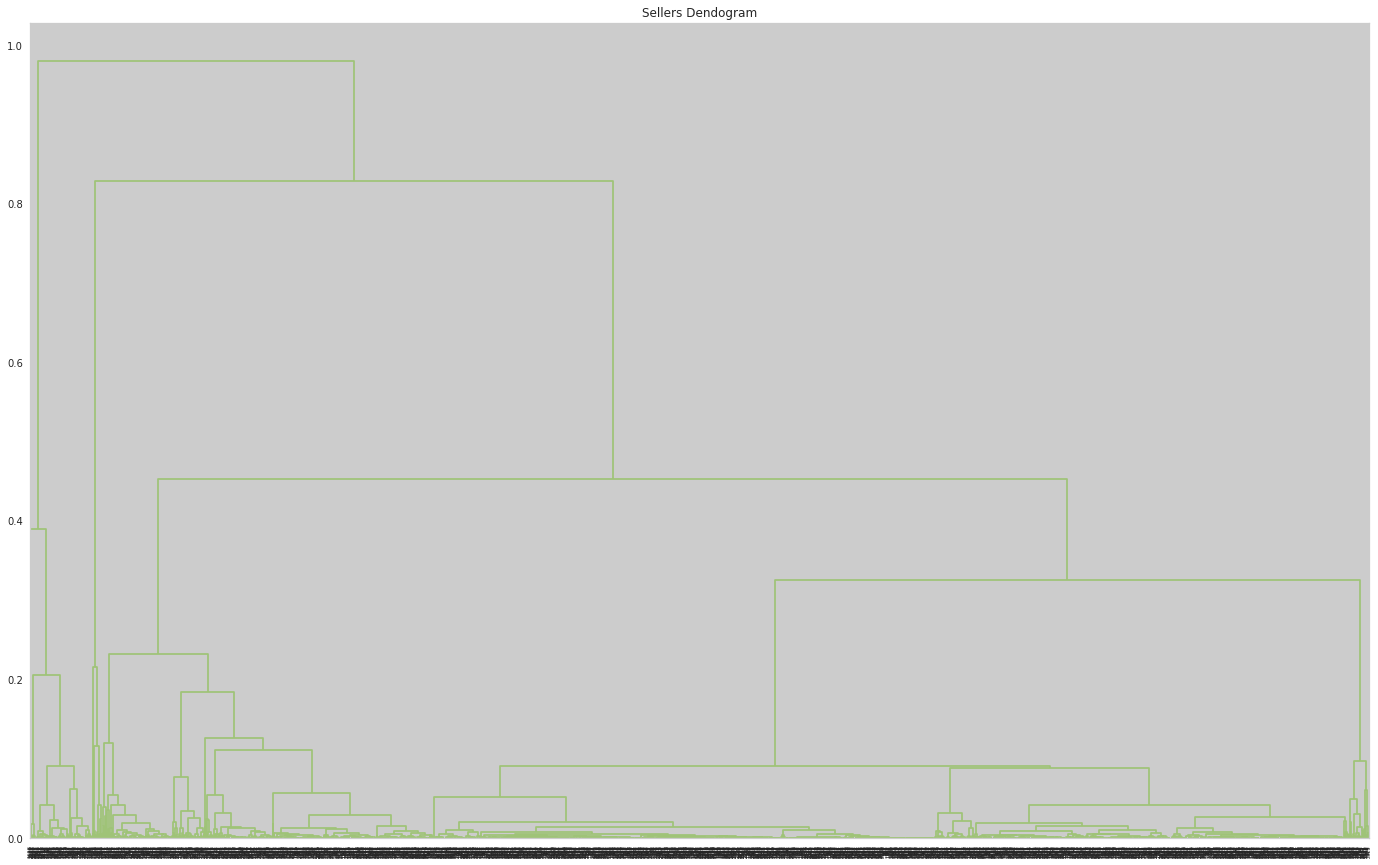

In [ ]:
plt.figure(figsize=(24, 15))  
plt.title("Sellers Dendogram")
link = shc.linkage(data_1_reduced, method='complete',metric='cosine')
dend = shc.dendrogram(link, color_threshold=11000)  

In [ ]:
X_hier = data_1_reduced.copy()
cluster = AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='complete')
agrup = cluster.fit_predict(X_hier) 
X_hier['labels'] = agrup
X_hier.groupby('labels').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_lenght':'median',
                                         'product_photos_qty':'median',
                                         'days diff between order placed and delivered date':'median',
                                         'days diff between order estimated and delivered date':'median'               
                                                          })

order_id        payment_value review_score product_description_lenght  \
          count median        median       median                     median   
labels                                                                         
0           719    6.0    250.583750     4.166667                 464.000000   
1           135    3.0    723.975000     4.166667                 374.000000   
2            21  926.0    120.750540     4.067916                 363.370892   
3            43  310.0    104.974039     4.171548                 505.907801   
4             1    1.0     87.370000     5.000000                   4.000000   
5          1988    7.0    108.256258     4.333333                 823.398390   

       product_photos_qty days diff between order placed and delivered date  \
                   median                                            median   
labels                                                                        
0                1.875000                                         12.000000   
1                2.000000                                         12.956522   
2                1.585470                                         12.731985   
3                1.887850                                         11.733333   
4                2.000000                                         24.000000   
5                1.878676                                         10.416199   

       days diff between order estimated and delivered date  
                                                     median  
labels                                                       
0                                              -12.186335    
1                                              -12.539683    
2                                              -11.745648    
3                                              -11.976923    
4                                              -66.000000    
5                                              -12.000000

We got the 6 clusters. However only cluster 0 and cluster 5 are large compared with rest of clusters. The rest of clusters are clusters of outliers.

#### Result of Hierarchical clustering

I've performed hierarchical clustering using 3 different distance metrics. We got good clusters from the Eucledian distance. But eucledian distance  able to identify very extreme outliers and grouped other outliers with nearest cluster. On other side Mahalanobis and Cosine distance measures were able to identify more outliers. From this we can make a conclusion that hierarchical clustering can be used to find outliers in the dataset and fail to give us proper clusters which we need for our analysis.

<a name="Section1.5"></a>

### DBSCAN

Density Based Spatial Clustering of Applications with Noise, DBSCAN for short, is a popular clustering algorithm that can be specially useful for outlier detection and clustering data of varying density. DBSCAN requires the user to specify two hyperparameters:


*   ε(epsilon or eps) - helps form a parameter around a data point.
*   minPts- helps identify the core points (points in a dense area). These are the minimum number of core points to be present within the parameter defined above for a cluster to form

After DBSCAN completes, there will be 3 types of data points identified: 1) core, 2) border, and 3) noise. Thus, DBSCAN “understands” the concept of noise or anomalies and is sensitive to it while clustering. It will therefore assign, for instance, a -1 as cluster number to data points that it finds in sparsely populated regions and help us identify outliers.





In [ ]:
X_DBSCAN = data_1_reduced.copy()

def DBSCAN_method(data):
    # Making sure we select only numeric features
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                            'uint8']).columns)
    # Normalize data and transform 
    preprocessor = ColumnTransformer([
            ('scaler', scaler, numerical_features)])

    DBSCAN_model = Pipeline([("preprocessor", preprocessor),
                                ("kmeans", DBSCAN(eps=0.07, min_samples =8,algorithm = 'ball_tree'))])
    agrup= DBSCAN_model.fit_predict(data)
    return agrup

In [ ]:
X_DBSCAN['labels'] = DBSCAN_method(X_DBSCAN)
X_DBSCAN.groupby('labels').agg({'order_id':['count','median'],
                                         'payment_value':'median',
                                         'review_score':'median',
                                         'product_description_lenght':'median',
                                         'product_photos_qty':'median',
                                         'days diff between order placed and delivered date':'median',
                                         'days diff between order estimated and delivered date':'median'               
                                                          })

order_id        payment_value review_score product_description_lenght  \
          count median        median       median                     median   
labels                                                                         
-1          684    4.0    176.865000     4.000000                1146.702068   
 0         2180    8.0    127.183333     4.333333                 649.990141   
 1           10    1.0    299.183750     5.000000                 805.000000   
 2            5   10.0    133.598571     4.181818                2182.142857   
 3            7    2.0    171.633333     5.000000                 457.000000   
 4           13    1.0    148.680000     1.000000                 438.000000   
 5            8    1.0    106.545000     1.000000                 313.000000   

       product_photos_qty days diff between order placed and delivered date  \
                   median                                            median   
labels                                                                        
-1               2.666667                                         12.614067   
 0               1.666667                                         10.500000   
 1               5.000000                                          9.250000   
 2               1.000000                                         12.714286   
 3               5.000000                                         11.000000   
 4               1.000000                                         11.000000   
 5               1.000000                                         30.000000   

       days diff between order estimated and delivered date  
                                                     median  
labels                                                       
-1                                             -11.887500    
 0                                             -12.000000    
 1                                              -8.500000    
 2                                              -9.571429    
 3                                             -14.000000    
 4                                             -16.000000    
 5                                               7.250000

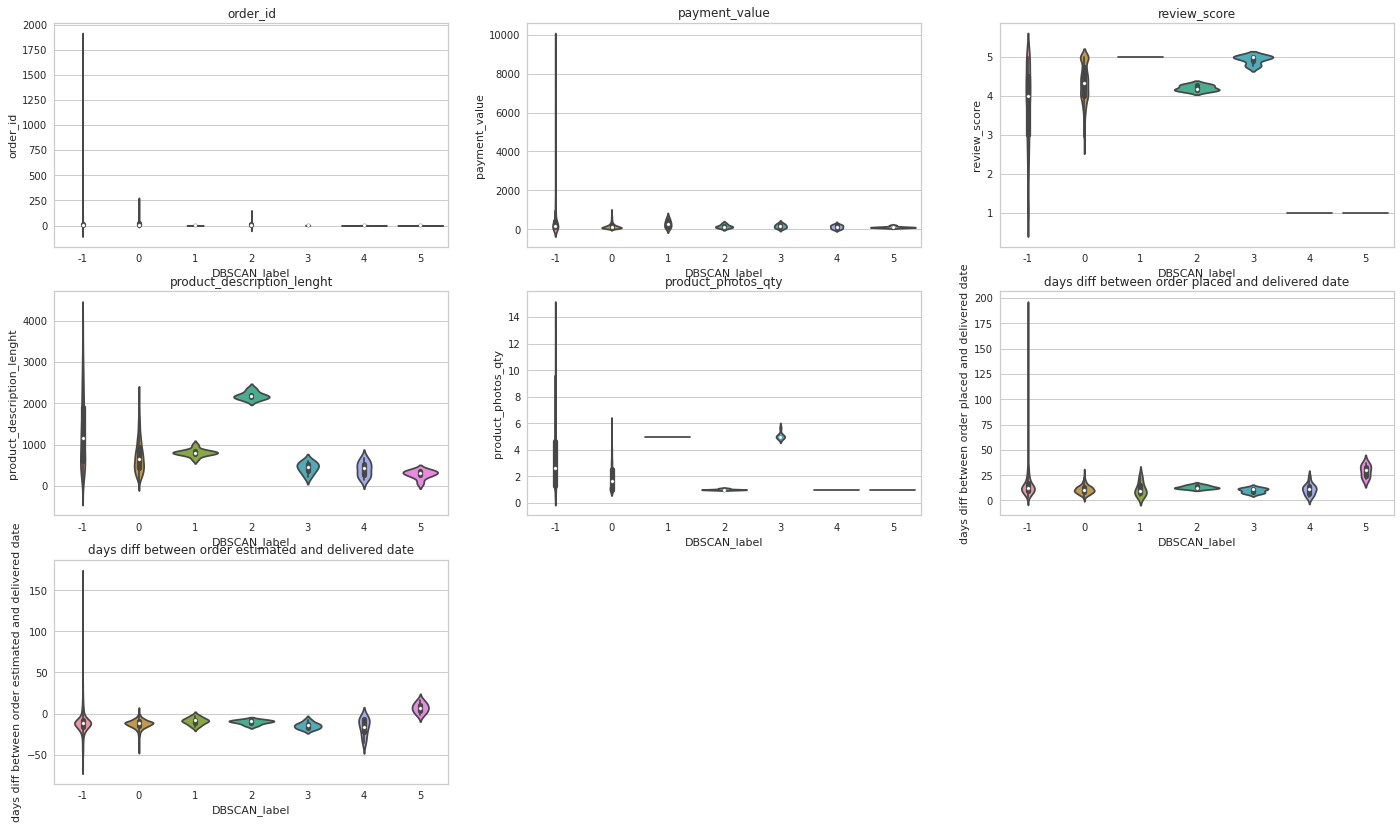

In [ ]:
n_plot = 331
fig = plt.figure(figsize=(24,14))
for i in X_DBSCAN:
  if i!='labels':
    axes = fig.add_subplot(n_plot) 
    sns.violinplot(x = X_DBSCAN['labels'],y = X_DBSCAN[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('DBSCAN_label')
    n_plot = n_plot+1

After decresing eps to 0.07 and min samples to 8 DBSCAN able to give us 6 clusters ( and one extra cluster of outlier). Cluster 0 is big enough and rest of cluster are very small. DBSCAN is not working well on our dataset. The reason behind this might be our datapoints in our dataset are too dense. 

<a name="Section1.6"></a>

### Results: Clustering

We have analyzed the data using 3 clustering methods: 1. K-means, 2. Hierarchical and 3. DBSCAN. After analysing the data, I realised we can't use the Hierarchical and DBSCAN clustering methods on our dataset as it contains too many outliers and the rest points are too dense. In other words, a few sellers are too different from the rest of the sellers. One reason behind this could be one-time sellers. As we saw in both Hierarchical and DBSCAN, we got a cluster where payment value was too much higher than the rest of the clusters, product description length was too long or short, the difference between estimated delivery date and actual delivery date was too low (in negative) or too high (too late). However, we did not find this information through K-means clustering as K-mean clustering grouped outliers in the nearest cluster and hence mostly all clusters are too spread (high difference between min and max values).

In each section (K-mean, Hierarchical, and DBSCAN) we have seen and analysed the common traits between different cluster of sellers and their differences. Another interesting to notice is that K-means, Hierarchical, and DBSCAN Clusters delivered very different results.

<a name="Section2"></a>

# Are there any patterns in customer purchase?  Do some itmes occur frequently in a transaction?


## Association Rule Mining (ARM)

Association rule mining is a Data mining concept to discover associations and relationships between variables. 

There are 3 measures of ARM. 


*   Support : How often items in A and items in B occur together relative to all transactions.
                Sup(A,B) = P(A,B) = (Count of A and B togather / Total Transactions)

*   Confidence : How often items in A and items in B occur together – relative to transactions that contain A
                Conf(A,B) = P(B/A) = P(A,B)/P(A) 

*   Lift :  the ratio of the observed frequency of co-occurrence of our items and the expected frequency.
                Lift(A,B) = P(A,B)/P(A)P(B) = P(A|B)/P(A)

                * Lift(A,B)=1  A and B are independent
                * Lift(A,B)<1  A and B are negatively correlated
                * Lift(A,B)>1  A and B are positively correlated







Famous Algorithms
*   Apriori Algorithm - 
                * Uses Apriori property and join, pure property 
                * Uses breadth first search method
                * Requires large memory space as they deal with large number of candidate itemset generation
                * Performs multiple scans for generating candidate set
                * Execution time is more wasted in producing candidates every time


*   FP-growth Algorirthm
                * Constructs conditional pattern free and conditional pattern base from the database which satisfies the minimum support.
                * Uses divide and conquer method
                * Requires less memory due to its compact structure they discover the frequent itemsets without candidate itemset generation
                * Scans the database only twice.
                * Execution time is less comapred with Apriori





In [ ]:
#pip install mlxtend

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from mlxtend.frequent_patterns import fpgrowth

To answer which products customer frequently purchase we just need transaction and products data. 

<a name="Section2.1"></a>

#### EDA

In [ ]:
product_category = pd.read_csv('https://raw.githubusercontent.com/swapnilsethi/Machine-Learning-and-Neural-Network/main/ML%20Project/product_category_name_translation.csv')
products = pd.read_csv('https://raw.githubusercontent.com/swapnilsethi/Machine-Learning-and-Neural-Network/main/ML%20Project/olist_products_dataset.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/swapnilsethi/Machine-Learning-and-Neural-Network/main/ML%20Project/olist_customers_dataset.csv')
orders = pd.read_csv('https://raw.githubusercontent.com/swapnilsethi/Machine-Learning-and-Neural-Network/main/ML%20Project/olist_orders_dataset.csv')
order_items = pd.read_csv('https://raw.githubusercontent.com/swapnilsethi/Machine-Learning-and-Neural-Network/main/ML%20Project/olist_order_items_dataset.csv')

In [ ]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


We need unique customers with their order numbers

In [ ]:
# Merge Customers with Orders
ARM_df= customers[['customer_unique_id','customer_id']].merge(orders[['order_id','customer_id']],
               left_on='customer_id', right_on='customer_id', how='left').drop(columns = ['customer_id'])

In [ ]:
ARM_df.head()

,customer_unique_id,order_id
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f


In [ ]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
ARM_df= ARM_df.merge(order_items[['order_id','product_id']],
               left_on='order_id', right_on='order_id', how='left').drop(columns = ['order_id'])

In [ ]:
ARM_df.shape

(113425, 2)

In [ ]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
ARM_df= ARM_df.merge(products[['product_category_name','product_id']],
               left_on='product_id', right_on='product_id', how='left')

In [ ]:
ARM_df.head()

,customer_unique_id,product_id,product_category_name
0,861eff4711a542e4b93843c6dd7febb0,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio
1,290c77bc529b7ac935b93aa66c333dc3,4aa6014eceb682077f9dc4bffebc05b0,utilidades_domesticas
2,060e732b5b29e8181a18229c7b0b2b5e,bd07b66896d6f1494f5b86251848ced7,moveis_escritorio
3,259dac757896d24d7702b9acbbff3f3c,a5647c44af977b148e0a3a4751a09e2e,moveis_escritorio
4,345ecd01c38d18a9036ed96c73b8d066,9391a573abe00141c56e38d84d7d5b3b,casa_conforto


In [ ]:
ARM_df= ARM_df.merge(product_category[['product_category_name','product_category_name_english']],
               left_on='product_category_name', right_on='product_category_name', how='left').drop(columns = ['product_category_name'])

In [ ]:
ARM_df.head()

,customer_unique_id,product_id,product_category_name_english
0,861eff4711a542e4b93843c6dd7febb0,a9516a079e37a9c9c36b9b78b10169e8,office_furniture
1,290c77bc529b7ac935b93aa66c333dc3,4aa6014eceb682077f9dc4bffebc05b0,housewares
2,060e732b5b29e8181a18229c7b0b2b5e,bd07b66896d6f1494f5b86251848ced7,office_furniture
3,259dac757896d24d7702b9acbbff3f3c,a5647c44af977b148e0a3a4751a09e2e,office_furniture
4,345ecd01c38d18a9036ed96c73b8d066,9391a573abe00141c56e38d84d7d5b3b,home_confort


##### Grouping data based on customer_unique_id and product_category_name_english

In [ ]:
ARM_df_prod_cat = ARM_df.groupby('customer_unique_id')['product_category_name_english'].apply(list).reset_index(name='product_category_name_english')

In [ ]:
ARM_df_prod_cat

,customer_unique_id,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,[bed_bath_table]
1,0000b849f77a49e4a4ce2b2a4ca5be3f,[health_beauty]
2,0000f46a3911fa3c0805444483337064,[stationery]
3,0000f6ccb0745a6a4b88665a16c9f078,[telephony]
4,0004aac84e0df4da2b147fca70cf8255,[telephony]
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,"[health_beauty, health_beauty]"
96092,fffea47cd6d3cc0a88bd621562a9d061,[baby]
96093,ffff371b4d645b6ecea244b27531430a,[auto]
96094,ffff5962728ec6157033ef9805bacc48,[watches_gifts]


In [ ]:
ARM_df_prod_cat = ARM_df_prod_cat[ARM_df_prod_cat.product_category_name_english.str.len()>1]


In [ ]:
ARM_df_prod_catII = pd.DataFrame(ARM_df_prod_cat['product_category_name_english'].tolist())

In [ ]:
ARM_df_prod_catII

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,sports_leisure,sports_leisure,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,bed_bath_table,bed_bath_table,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,musical_instruments,musical_instruments,toys,toys,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,housewares,housewares,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,luggage_accessories,luggage_accessories,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11940,construction_tools_lights,construction_tools_lights,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
11941,perfumery,perfumery,perfumery,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
11942,signaling_and_security,signaling_and_security,signaling_and_security,signaling_and_security,signaling_and_security,signaling_and_security,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
11943,bed_bath_table,bed_bath_table,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
#Download file for further use in R 
#ARM_df_prod_catII.to_csv('transaction.csv')

##### Grouping data based on customer_unique_id and product_id


In [ ]:
ARM_df=ARM_df.dropna()
ARM_df_prod = ARM_df.groupby('customer_unique_id')['product_id'].apply(list).reset_index(name='product_id')
ARM_df_prod = ARM_df_prod[ARM_df_prod.product_id.str.len()>1]
ARM_df_prod = pd.DataFrame(ARM_df_prod['product_id'].tolist())
ARM_df_prod.to_csv('products_transaction.csv')

In [ ]:
ARM_df.head()

<a name="Section2.2"></a>

#### ARM Code in R

Here is a [link](https://github.com/swapnilsethi/Machine-Learning-and-Neural-Network/blob/main/ML%20Project/Notebooks/Unsupervised%20Clustering/ARM/Swapnil_Sethi_ARM.Rmd) for rmd file. Also attached file in the submission.

<a name="Section2.3"></a>

#### ARM Code in Python

In [ ]:
print(ARM_df.nunique())
print('\nshape of df:',ARM_df.shape)

customer_unique_id               94088
product_id                       32328
product_category_name_english       71
dtype: int64

shape of df: (111023, 3)


We have total 113425 orders in which store sold 32951 unique prodcuts across 71 categories. 

Firstly, we will perform ARM on Product categories and then we will perform ARM on the products.

In [ ]:
ARM_df_prod_cat = ARM_df[['customer_unique_id','product_category_name_english']]

Now, transform data. 

In [ ]:
txn_data = pd.get_dummies(
    data= ARM_df_prod_cat[[
        'customer_unique_id',
        'product_category_name_english'
    ]], 
    columns= ['product_category_name_english'],
    prefix= 'catg'
).groupby([
    'customer_unique_id',
]).sum()

txn_data = txn_data.reset_index()
txn_data.head()

,customer_unique_id,catg_agro_industry_and_commerce,catg_air_conditioning,catg_art,catg_arts_and_craftmanship,catg_audio,catg_auto,catg_baby,catg_bed_bath_table,catg_books_general_interest,...,catg_security_and_services,catg_signaling_and_security,catg_small_appliances,catg_small_appliances_home_oven_and_coffee,catg_sports_leisure,catg_stationery,catg_tablets_printing_image,catg_telephony,catg_toys,catg_watches_gifts
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
txn_data.shape

(94088, 72)

The column names are cleaned so that they make sense and help better understand the outputs of the mining algorithm. The whitespaces are re-introduced and the prefix catg is removed.

In [ ]:
cols = txn_data.columns
cols = cols.str.replace('catg_','')
cols = cols.str.replace('_',' ')
txn_data.columns = cols
txn_data.head(5)

,customer unique id,agro industry and commerce,air conditioning,art,arts and craftmanship,audio,auto,baby,bed bath table,books general interest,...,security and services,signaling and security,small appliances,small appliances home oven and coffee,sports leisure,stationery,tablets printing image,telephony,toys,watches gifts
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


FP Growth Algorithm is an efficeint and scalable mining method. It uses an extended prefix tree structure for storing compressed frequent patters, called FP tree.

The algorithm works in 2 steps. First step is to find all the frequent patters from the transaction database. A pattern is said to frequent if it has support more than the threshold set. Since the data avalaible is of 2 years, between 2016 and 2018, and the company started complete operations country wide in 2016, the threshold set is relatively low - 2. 
The second step of the algorithm is generating association rules from the frequent pattern sets found previously. These association rules are generated based on a threshold for confidence. Confidence here determines the probability of products of a frequent pattern set being bought together.

Convert to bianry columns since the actual quantity is not important.

In [ ]:
txn_data = txn_data.groupby('customer unique id').sum().reset_index()

for col in txn_data.columns[1:]:
    txn_data[col] = txn_data[col].apply(lambda x: 1 if x>0 else 0)
    
txn_data.head(5)

,customer unique id,agro industry and commerce,air conditioning,art,arts and craftmanship,audio,auto,baby,bed bath table,books general interest,...,security and services,signaling and security,small appliances,small appliances home oven and coffee,sports leisure,stationery,tablets printing image,telephony,toys,watches gifts
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
patterns = fpgrowth(txn_data.iloc[:,1:], min_support= 0.0002, use_colnames= True)

frequent_sets = patterns.sort_values('support', ascending= False)[:15]
frequent_sets.support = frequent_sets.support * len(txn_data)
frequent_sets

,support,itemsets
0,9145.0,(bed bath table)
1,8678.0,(health beauty)
5,7515.0,(sports leisure)
8,6557.0,(computers accessories)
22,6317.0,(furniture decor)
14,5821.0,(housewares)
16,5547.0,(watches gifts)
3,4152.0,(telephony)
21,3852.0,(auto)
11,3844.0,(toys)


In [ ]:
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules


In [ ]:
rules = association_rules(patterns, metric= 'confidence', min_threshold= 0.01)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(garden tools),(furniture decor),0.037082,0.067139,0.000489,0.013184,0.196372,-0.002001,0.945324
1,(home confort),(bed bath table),0.004209,0.097196,0.000574,0.136364,1.402972,0.000165,1.045352
2,(housewares),(bed bath table),0.061868,0.097196,0.000712,0.011510,0.118421,-0.005301,0.913316
3,(housewares),(furniture decor),0.061868,0.067139,0.000638,0.010308,0.153524,-0.003516,0.942576
4,(bed bath table),(furniture decor),0.097196,0.067139,0.001658,0.017059,0.254076,-0.004868,0.949050
5,(furniture decor),(bed bath table),0.067139,0.097196,0.001658,0.024695,0.254076,-0.004868,0.925663
6,(baby),(bed bath table),0.030376,0.097196,0.000393,0.012946,0.133196,-0.002559,0.914645
7,(baby),(cool stuff),0.030376,0.038421,0.000329,0.010847,0.282309,-0.000838,0.972123
8,(home construction),(furniture decor),0.005197,0.067139,0.000213,0.040900,0.609178,-0.000136,0.972642
